## 1.건축물의 화재 위험도 분석 및 예측 모델 제시

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os
import re
from sklearn.metrics import f1_score, recall_score, roc_auc_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, explained_variance_score, confusion_matrix
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, mean_squared_error
from sklearn.linear_model import LogisticRegression

from imblearn.over_sampling import SMOTE
import xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier, plot_importance
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

### 월별 평균 전처리

In [ ]:
# train.csv

df_train.drop(columns=['id'],inplace=True)
newmonth = ["avg_gas_01","avg_gas_02","avg_gas_03","avg_gas_04","avg_gas_05","avg_gas_06","avg_gas_07","avg_gas_08","avg_gas_09","avg_gas_10","avg_gas_11","avg_gas_12"]

# ele 월별 묶음 list 생성
ele_energy_us_month = [[] for i in range(12)]
for i in range(2014,2019):
  for j in range(1,13):
    if j<10:
      ele_energy_us_month[j-1].append("ele_engry_us_{}0{}".format(i,j))
    else:
      ele_energy_us_month[j-1].append("ele_engry_us_{}{}".format(i,j))
ele_energy_us_month

# gas 월별 묶음 list 생성
gas_energy_us_month = [[] for i in range(12)]
for i in range(2014,2019):
  for j in range(1,13):
    if j<10:
      gas_energy_us_month[j-1].append("gas_engry_us_{}0{}".format(i,j))
    else:
      gas_energy_us_month[j-1].append("gas_engry_us_{}{}".format(i,j))
gas_energy_us_month

df_train.iloc[:,17:137] = df_train.iloc[:,17:137].fillna(0) # ele 이랑 gas nan 값 0으로 채우기

In [ ]:
# 201401~201801 까지 5개년을 더해서 ele_engry_us_01 을 만듬. 이때 기록 있으면 count 증가해서 평균 만듦

gas_energy_us_m = []
ele_energy_us_m = []
for i in range(len(df_train)):
  j = 0
  months_g = []
  months_e = []
  for m in range(12):
    count_g = 0
    rec_value_g = 0
    count_e = 0
    rec_value_e = 0
    for y in range(5):
      if df_train.iloc[i][gas_energy_us_month[m][y]] > 0 :
        rec_value_g += df_train.iloc[i][gas_energy_us_month[m][y]]
        count_g += 1
      if df_train.iloc[i][ele_energy_us_month[m][y]] > 0 :
        rec_value_e += df_train.iloc[i][ele_energy_us_month[m][y]]
        count_e += 1  
        
    if count_g == 0:
      months_g.append(0)
    else:
      months_g.append(rec_value_g/count_g)

    if count_e == 0:
      months_e.append(0)
    else:
      months_e.append(rec_value_e/count_e)

  gas_energy_us_m.append(months_g)
  ele_energy_us_m.append(months_e)

#gas_energy_us_m
#ele_energy_us_m

avg_gas = ["avg_gas_energy_us_%d"%(i) for i in range(1,13)] 
avg_ele = ["avg_ele_energy_us_%d"%(i) for i in range(1,13)]

tmp_avg_gas = pd.DataFrame(np.array(gas_energy_us_m),columns=avg_gas) # avg_gas이름으로 된 591999*12 로 된 gas_energy_us_m 데이터를 pandas로 변환
tmp_avg_ele = pd.DataFrame(np.array(ele_energy_us_m),columns=avg_ele)

df_train.drop(columns = df_train.columns[17:137],axis=1,inplace=True)

newdata = pd.concat([df_train,tmp_avg_ele,tmp_avg_gas],axis=1)

df_train_tmp = pd.read_csv("/content/drive/MyDrive/SNU_Fintech/SNU - 5조/ML_Fire_Prediction/Data/train_avgfiltered.csv")

In [ ]:
# validation.csv
df_test.drop(columns=['id'],inplace=True)
newmonth = ["avg_gas_01","avg_gas_02","avg_gas_03","avg_gas_04","avg_gas_05","avg_gas_06","avg_gas_07","avg_gas_08","avg_gas_09","avg_gas_10","avg_gas_11","avg_gas_12"]

# ele 월별 묶음 list 생성
ele_energy_us_month = [[] for i in range(12)]
for i in range(2014,2019):
  for j in range(1,13):
    if j<10:
      ele_energy_us_month[j-1].append("ele_engry_us_{}0{}".format(i,j))
    else:
      ele_energy_us_month[j-1].append("ele_engry_us_{}{}".format(i,j))
ele_energy_us_month

# gas 월별 묶음 list 생성
gas_energy_us_month = [[] for i in range(12)]
for i in range(2014,2019):
  for j in range(1,13):
    if j<10:
      gas_energy_us_month[j-1].append("gas_engry_us_{}0{}".format(i,j))
    else:
      gas_energy_us_month[j-1].append("gas_engry_us_{}{}".format(i,j))
gas_energy_us_month

df_test.iloc[:,17:137] = df_test.iloc[:,17:137].fillna(0) # ele 이랑 gas nan 값 0으로 채우기

In [ ]:
# 201401~201801 까지 5개년을 더해서 ele_engry_us_01 을 만듬. 이때 기록 있으면 count 증가해서 평균 만듦

gas_energy_us_m = []
ele_energy_us_m = []
for i in range(len(df_test)):
  j = 0
  months_g = []
  months_e = []
  for m in range(12):
    count_g = 0
    rec_value_g = 0
    count_e = 0
    rec_value_e = 0
    for y in range(5):
      if df_test.iloc[i][gas_energy_us_month[m][y]] > 0 :
        rec_value_g += df_test.iloc[i][gas_energy_us_month[m][y]]
        count_g += 1
      if df_test.iloc[i][ele_energy_us_month[m][y]] > 0 :
        rec_value_e += df_test.iloc[i][ele_energy_us_month[m][y]]
        count_e += 1  
        
    if count_g == 0:
      months_g.append(0)
    else:
      months_g.append(rec_value_g/count_g)

    if count_e == 0:
      months_e.append(0)
    else:
      months_e.append(rec_value_e/count_e)

  gas_energy_us_m.append(months_g)
  ele_energy_us_m.append(months_e)

#gas_energy_us_m
#ele_energy_us_m

avg_gas = ["avg_gas_energy_us_%d"%(i) for i in range(1,13)] 
avg_ele = ["avg_ele_energy_us_%d"%(i) for i in range(1,13)]

tmp_avg_gas = pd.DataFrame(np.array(gas_energy_us_m),columns=avg_gas) # avg_gas이름으로 된 591999*12 로 된 gas_energy_us_m 데이터를 pandas로 변환
tmp_avg_ele = pd.DataFrame(np.array(ele_energy_us_m),columns=avg_ele)

df_test.drop(columns = df_test.columns[17:137],axis=1,inplace=True)

newdata = pd.concat([df_test,tmp_avg_ele,tmp_avg_gas],axis=1)

df_test_tmp = pd.read_csv("/content/drive/MyDrive/SNU_Fintech/SNU - 5조/ML_Fire_Prediction/Data/train_avgfiltered.csv")

## 2.결측치 처리 Version1

In [ ]:
df_test = pd.read_csv('/Users/Ugeon/Anaconda/SNU_FinTech/Team Project/화재 예측/Fire_Data/validation.csv')
df_train = pd.read_csv('/Users/Ugeon/Anaconda/SNU_FinTech/Team Project/화재 예측/Fire_Data/train_avgfiltered.csv',index_col=[0],infer_datetime_format='dt_of_fr')

In [ ]:
df_train.fr_yn = df_train.fr_yn.map({'Y':1,"N":0})
df_test.fr_yn = df_test.fr_yn.map({'Y':1,"N":0})

df_train.dt_of_fr = pd.to_datetime(df_train.dt_of_fr)
df_train['month'] = df_train.dt_of_fr.dt.month 
df_train.drop(columns=['dt_of_fr'],inplace=True)

drop_col = ['rgnl_ar_nm2', 'rd_sd_nm','emd_nm','slf_fr_brgd_yn', 'fr_fghtng_fclt_spcl_css_5_yn',
            'fr_fghtng_fclt_spcl_css_6_yn'] #'dt_of_athrztn']
df_train.drop(columns=drop_col,inplace=True)
# df_train.shape

df_test.dt_of_fr = pd.to_datetime(df_test.dt_of_fr)
df_test['month'] = df_test.dt_of_fr.dt.month 
df_test.drop(columns=['dt_of_fr'],inplace=True)

df_test.drop(columns=drop_col,inplace=True)
df_train.shape

(59199, 77)

In [ ]:
fire_y = df_train[df_train.fr_yn==1]
print(fire_y.shape)

# 불이 난 데이터들 중에 80% 이상 nan값을 가지는 열들 제거
low_corr_idx=[]
low_corr_col=[]

for idx,cnt in enumerate(fire_y.isnull().sum()):
    if cnt >= (7657*0.8):
        low_corr_col.append(fire_y.columns[idx])
        low_corr_idx.append(idx)
        
df_train.drop(columns=low_corr_col,inplace=True)
df_test.drop(columns=low_corr_col,inplace=True)
print(df_train.shape)

(7657, 77)
(59199, 61)


In [ ]:
# 승인날짜 결측치 처리 : 있음(1) 없음(0)
df_train.dt_of_athrztn.fillna(123456,inplace=True)
df_train.dt_of_athrztn = np.where(df_train.dt_of_athrztn == 123456,0,1)

df_train.loc[(df_train['dt_of_athrztn']==0) & (df_train['bldng_us'].isnull()==True), 'bldng_us'] = '미확인'
df_train.bldng_us.fillna('없음',inplace=True)

df_test.dt_of_athrztn.fillna(123456,inplace=True)
df_test.dt_of_athrztn = np.where(df_test.dt_of_athrztn == 123456,0,1)

df_test.loc[(df_test['dt_of_athrztn']==0) & (df_test['bldng_us'].isnull()==True), 'bldng_us'] = '미확인'
df_test.bldng_us.fillna('없음',inplace=True)

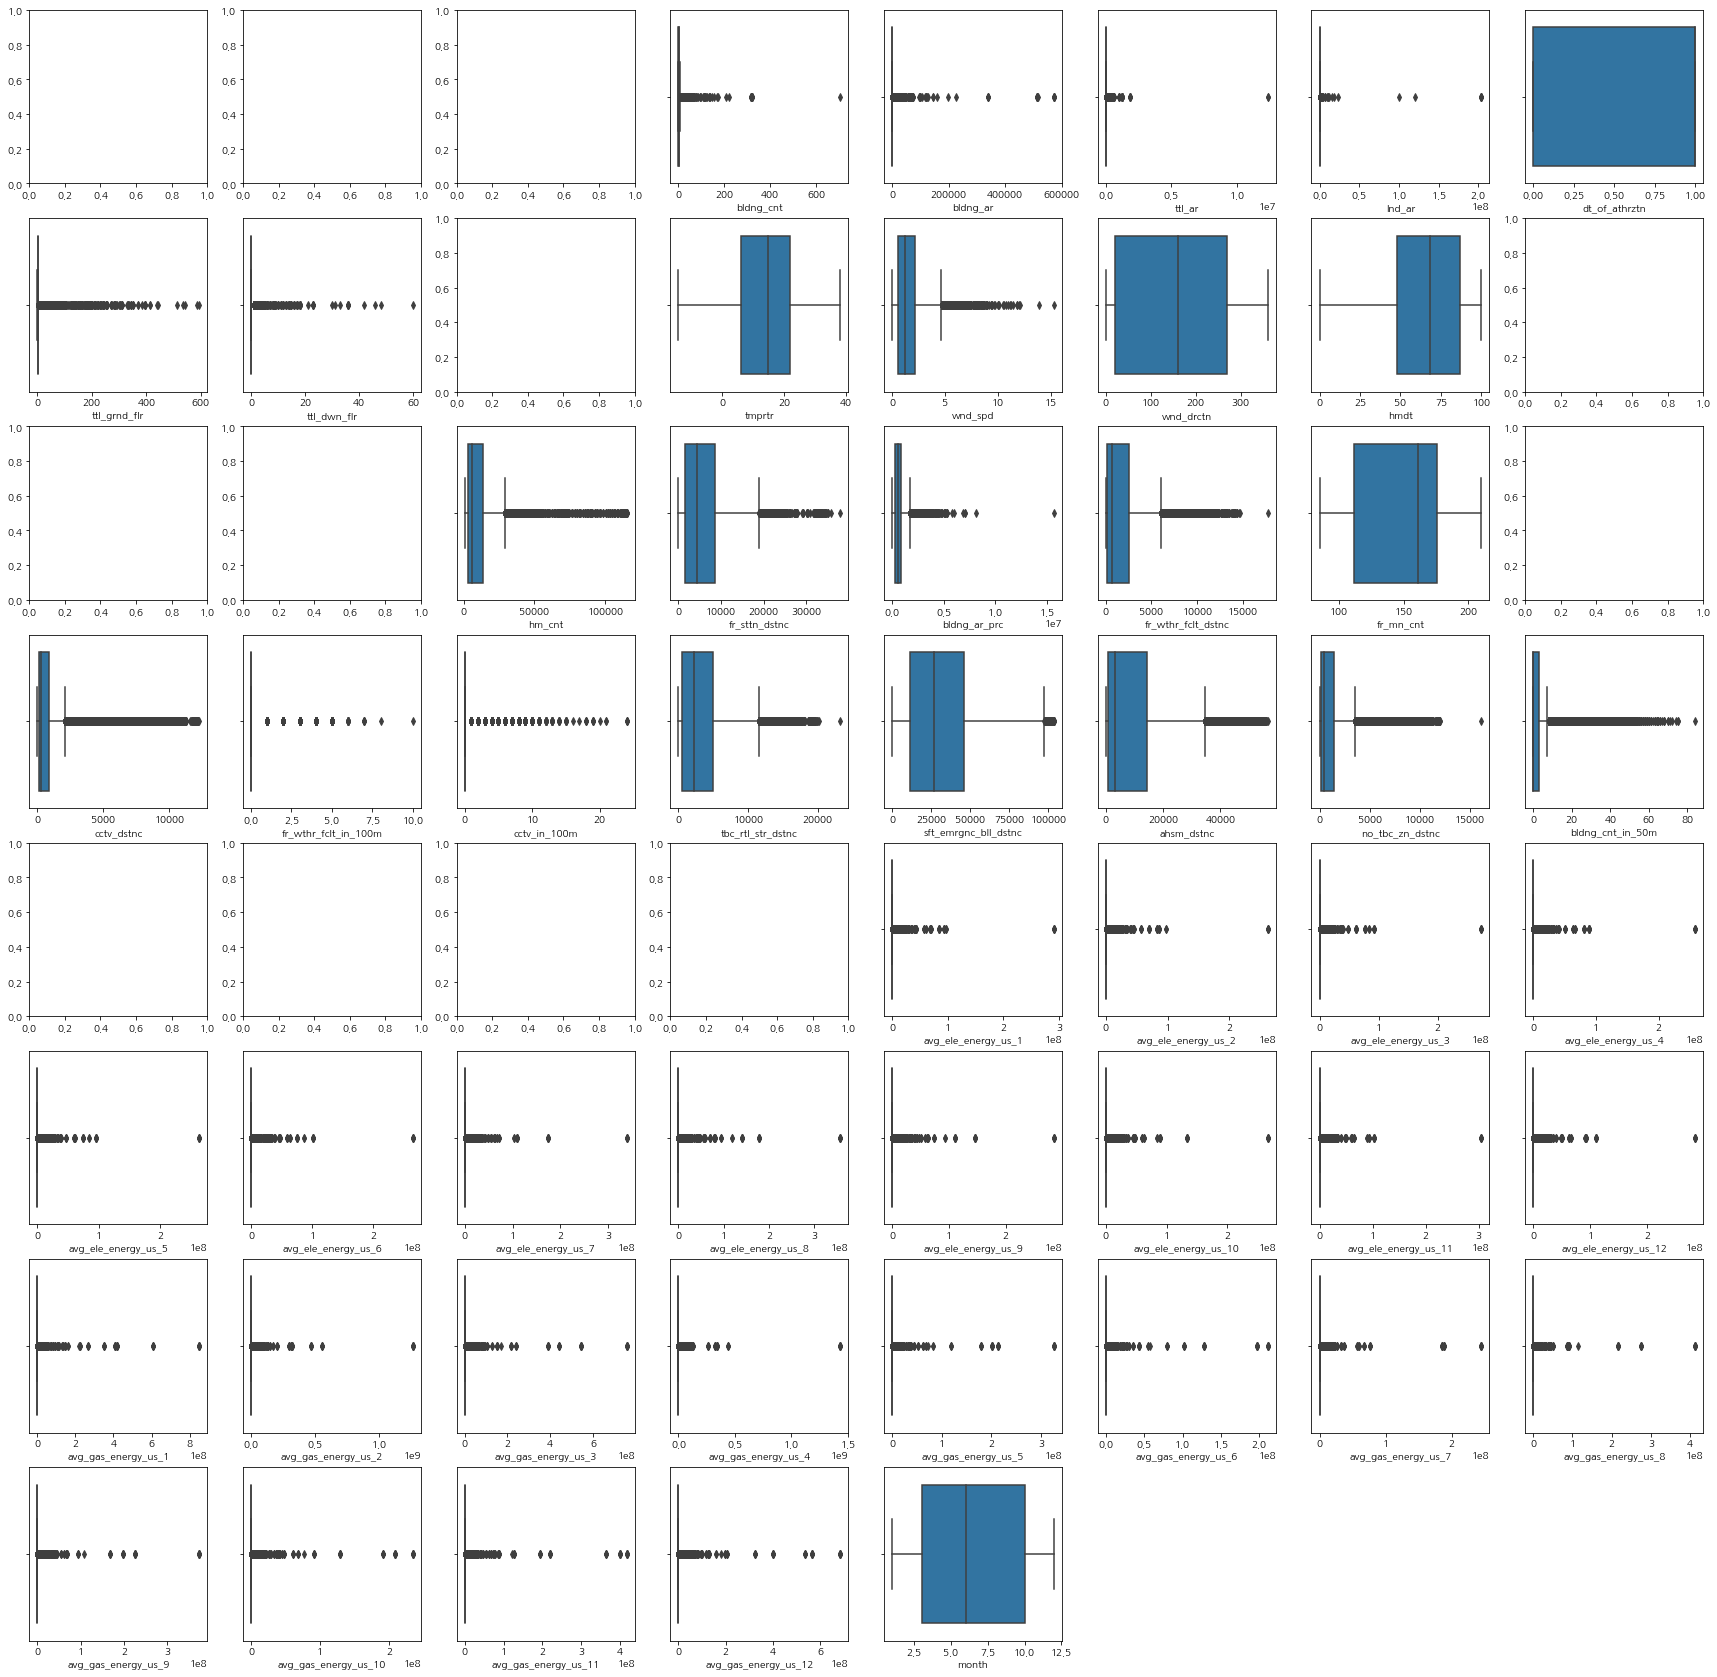

In [ ]:
plt.figure(figsize=(30,30))

for i in range(len(df_train.columns)):
    plt.subplot(8,8,i+1)
    col = df_train.columns[i]
    if df_train[col].dtypes != object:
        sns.boxplot(data=df_train, x=df_train[col])

In [ ]:
# 결측치 채우기 version2
    # numerical_cat은 mean으로
    # ordinal_cat은 most_freq으로

cat_col_idx = np.where(df_train.drop(columns=['fr_yn']).dtypes == object)[0]
cat_col_list =[]
for idx in cat_col_idx:
    col = df_train.drop(columns=['fr_yn']).columns[idx]
    cat_col_list.append(col)


ordinal_cat = ['month','ttl_grnd_flr','ttl_dwn_flr','bldng_cnt_in_50m',]

non_numerical_cat = set(cat_col_list + ordinal_cat)
numerical_cat = set(df_train.drop(columns=['fr_yn']).columns)
numerical_cat = list(numerical_cat.difference(non_numerical_cat))

bldng_us_list = df_train.bldng_us.unique()
# temp_1 = df_train.copy().drop(columns=['fr_yn'])

for bldng in bldng_us_list:
    temp_data = df_train[df_train.bldng_us == bldng]
    if bldng in list(df_test.bldng_us):
        temp_data2 = df_test[df_test.bldng_us == bldng]
    
    # ordinal_cat
    for column in ordinal_cat:
        val_cnt = temp_data[column].value_counts()
        if len(val_cnt) != 0:
            freq = val_cnt.idxmax()
        elif len(val_cnt) == 0:
            freq = 0
        temp_data[column].fillna(freq,inplace=True)
        if freq in list(temp_data2[column]):
            temp_data2[column].fillna(freq,inplace=True)

    # numerical_cat
    for num_col in numerical_cat:
        val_cnt = temp_data[num_col].value_counts()
        if len(val_cnt) != 0:
            mean = temp_data[num_col].mean()
        elif len(val_cnt) == 0:
            mean = 0
            
        temp_data[num_col].fillna(mean,inplace=True)
        if num_col in temp_data2.columns:
            temp_data2[num_col].fillna(mean,inplace=True)
        
    # categorical_cat
    for column in cat_col_list:
        val_cnt = temp_data[column].value_counts()
        if len(val_cnt) != 0:
            freq = val_cnt.idxmax()
        elif len(val_cnt) == 0:
            freq = '없음'
            
        temp_data[column].fillna(freq,inplace=True)
        if freq in list(temp_data2[column]):
            temp_data2[column].fillna(freq,inplace=True)
    
    df_train.update(temp_data)
    df_test.update(temp_data2)

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

train_temp = df_train.copy()
ordinal_encoder = OrdinalEncoder()
train_temp_ord = pd.DataFrame(ordinal_encoder.fit_transform(train_temp[cat_col_list]),index=train_temp.index,
                                                          columns=cat_col_list)

train_temp.update(train_temp_ord)
train_temp[cat_col_list]



,bldng_us,bldng_archtctr,bldng_us_clssfctn,jmk,rgnl_ar_nm,lnd_us_sttn_nm,mlt_us_yn,us_yn,dngrs_thng_yn,blk_dngrs_thng_mnfctr_yn,cltrl_hrtg_yn
0,9,8,7,4,13,11,0,2,0,0,0
1,13,10,6,4,1,11,0,2,0,0,0
2,1,16,7,3,17,24,0,2,0,0,0
3,9,11,7,4,15,11,0,2,0,0,0
4,13,10,6,13,14,30,0,2,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
59194,10,1,3,6,1,34,0,2,0,0,0
59195,13,10,6,4,1,21,0,2,0,0,0
59196,13,10,6,15,1,5,0,2,0,0,0
59197,29,1,5,3,4,13,0,2,0,0,0


<AxesSubplot:>

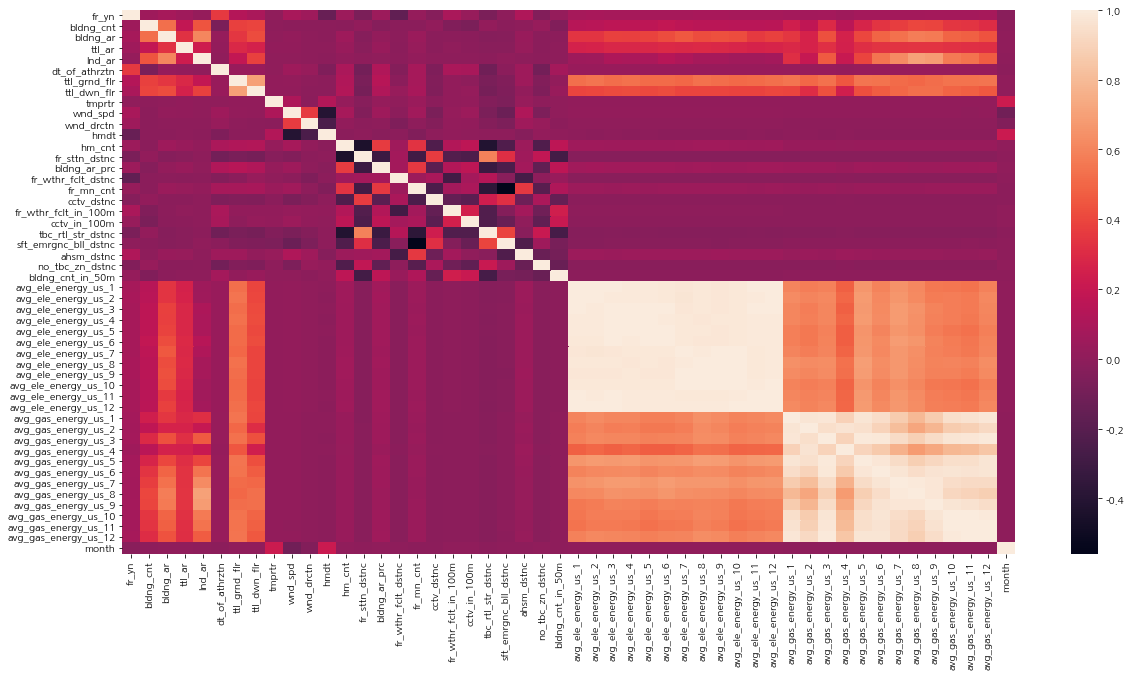

In [ ]:
plt.figure(figsize=(20,10))
sns.heatmap(train_temp.corr())

In [ ]:
# target과 상관이 높은 변수  : hmdt, fr_wthr_fclt_dstnc
train_temp[['fr_yn','hmdt','fr_wthr_fclt_dstnc']].corr()

,fr_yn,hmdt,fr_wthr_fclt_dstnc
fr_yn,1.000000,-0.140291,-0.165280
hmdt,-0.140291,1.000000,-0.010154
fr_wthr_fclt_dstnc,-0.165280,-0.010154,1.000000


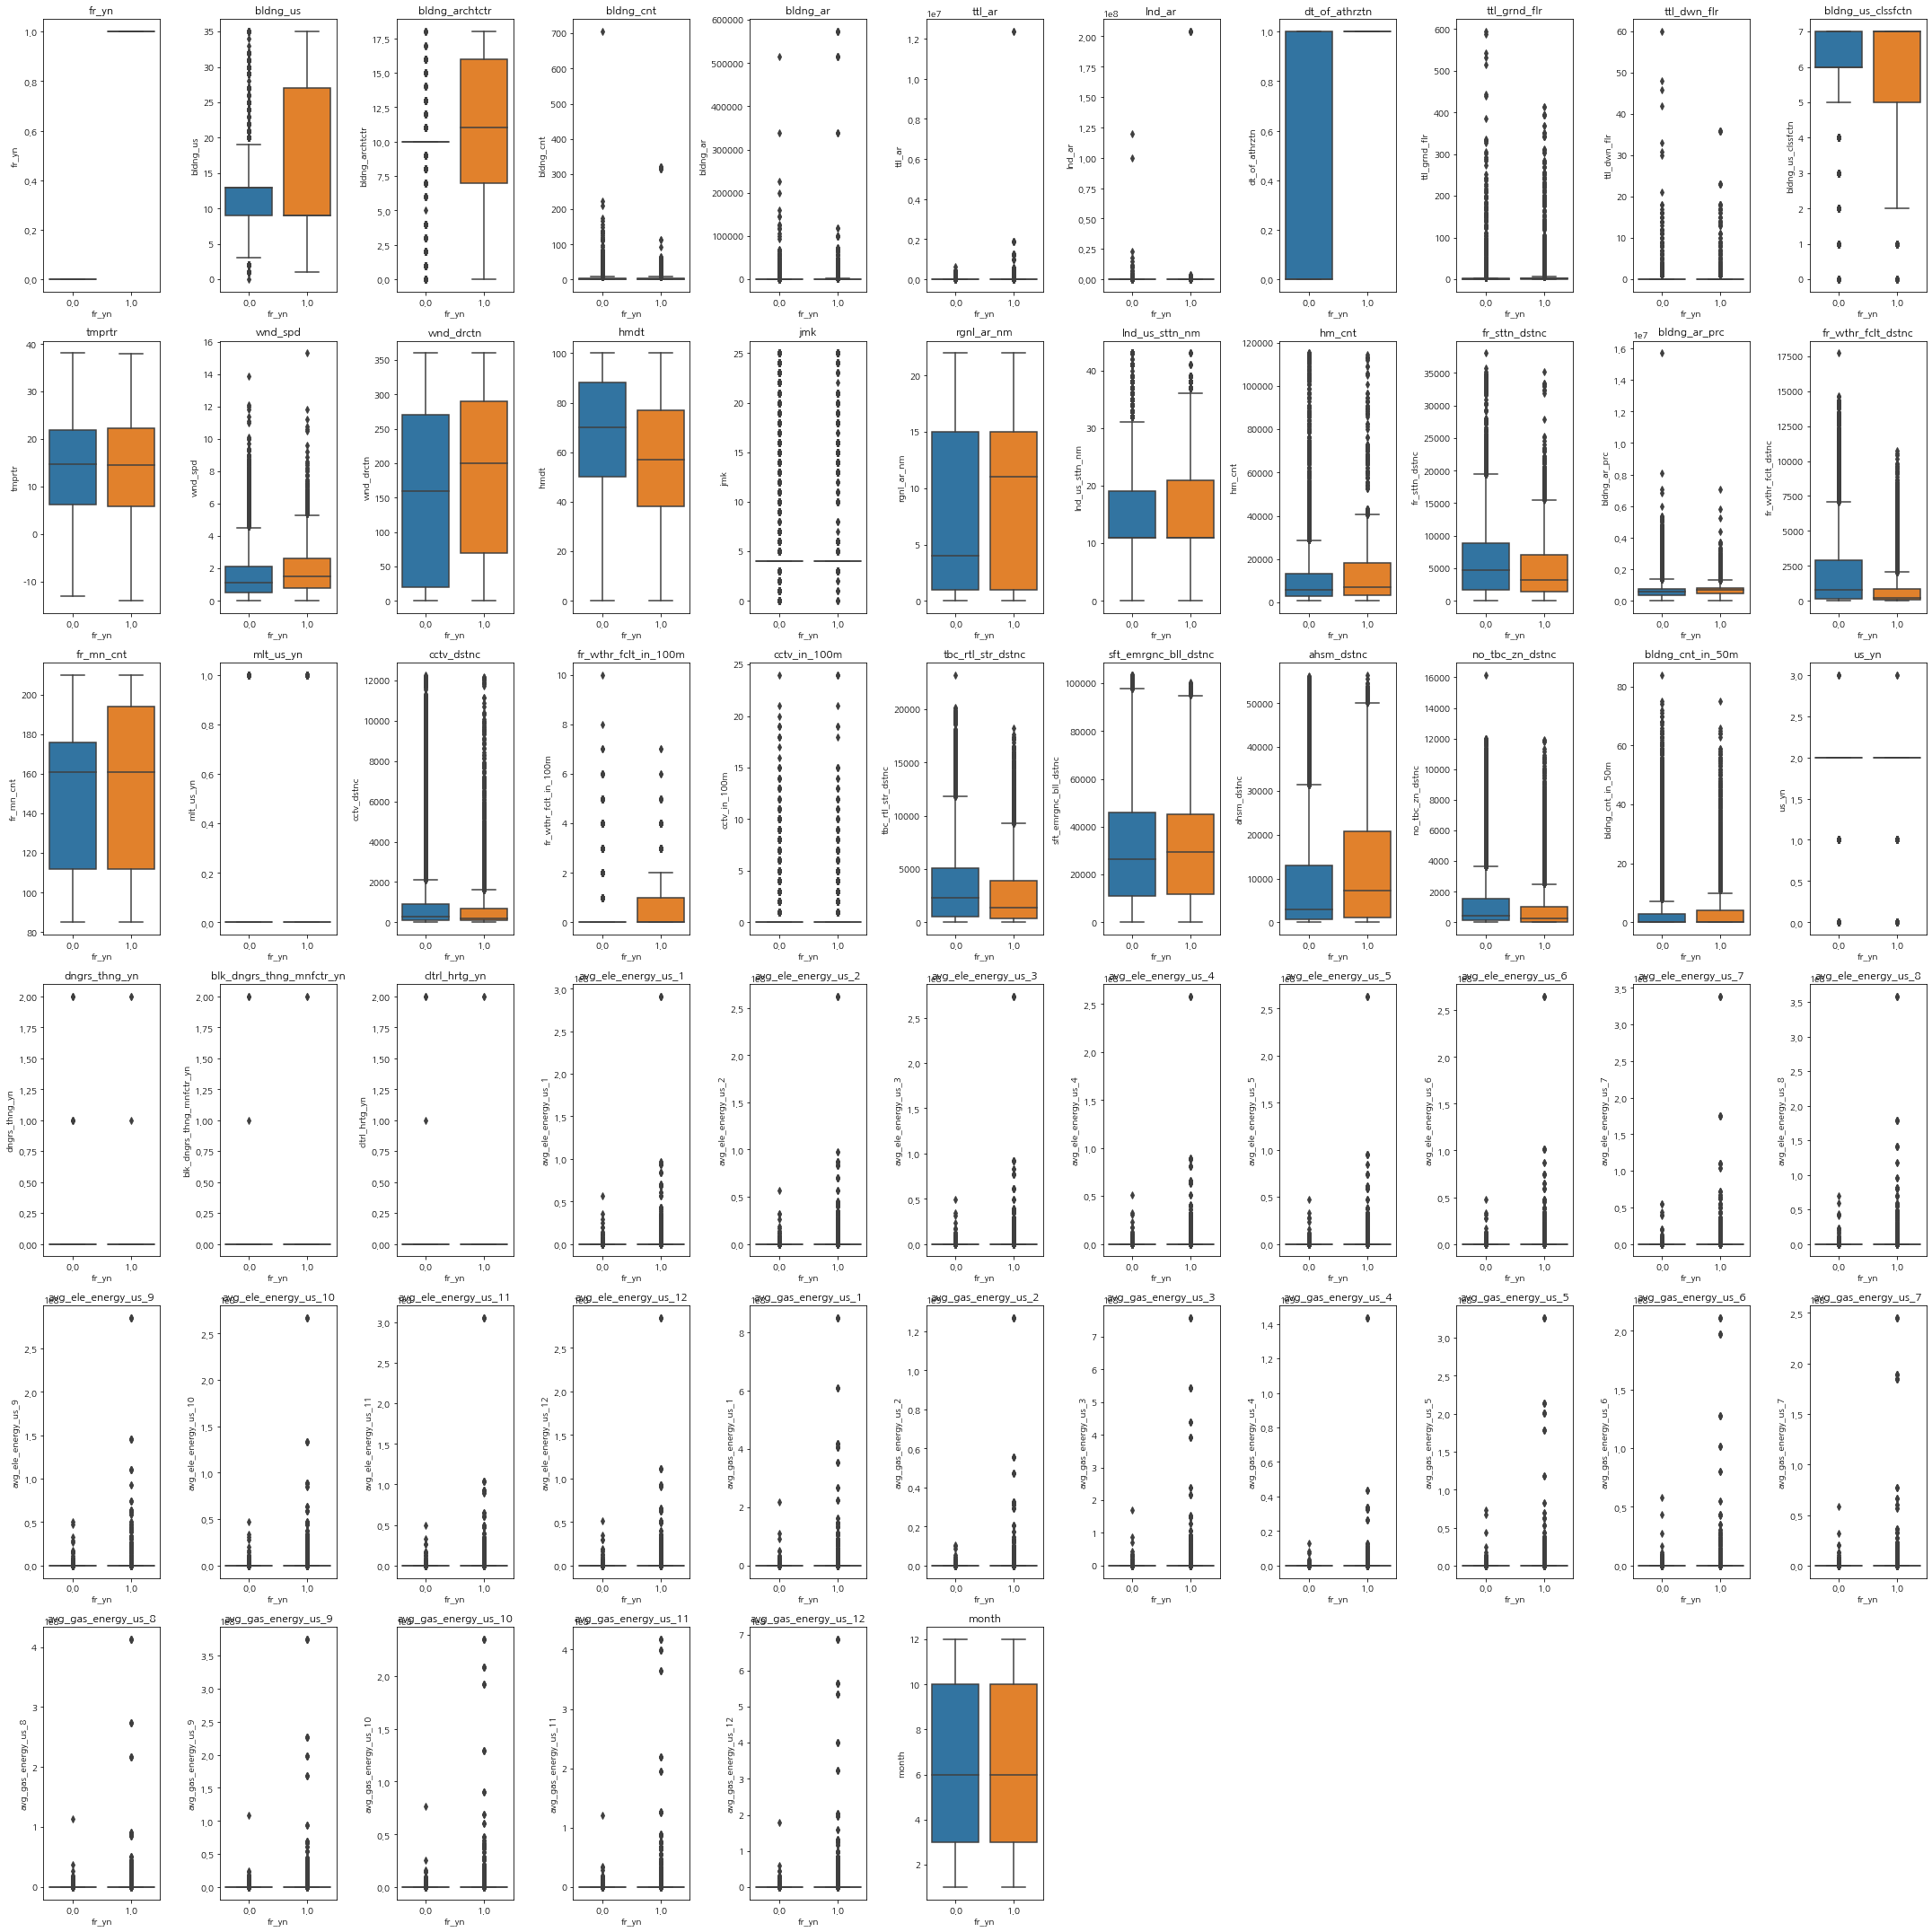

In [ ]:
plt.figure(figsize=(30,30))

for i in range(len(train_temp.columns)):
    plt.subplot(6,11,i+1)
    col = train_temp.columns[i]
#     if df_train[col].dtypes != object:
    sns.boxplot(data=train_temp, x='fr_yn',y=col)
    plt.title(col)
plt.tight_layout()

In [ ]:
X_train = df_train.drop(columns=['fr_yn'])
y_train = df_train['fr_yn']
X_test = df_test.drop(columns=['fr_yn'])
y_test = df_test['fr_yn']

# train 더미변수
cat_col_idx = np.where(X_train.dtypes == object)[0]
cat_col_list =[]

for idx in cat_col_idx:
    col = X_train.columns[idx]
    cat_col_list.append(col)
    temp_data = pd.get_dummies(X_train[col],prefix="{}".format(col))
    X_train = X_train.merge(temp_data,left_index=True,right_index=True)

X_train.drop(columns=cat_col_list,inplace=True)    
# X = X.rename(columns = lambda x : re.sub('[^A-Za-z0-9ㄱ-ㅣ가-힣_]]+', '', x))
X_train = X_train.rename(columns = lambda x : re.sub('[^A-Za-z0-9ㄱ-ㅣ가-힣_]+', '', x))

# test 더미변수
test_cat_col_idx = np.where(X_test.dtypes == object)[0]
test_cat_col_list =[]

for idx in test_cat_col_idx:
    col = X_test.columns[idx]
    cat_col_list.append(col)
    temp_data = pd.get_dummies(X_test[col],prefix="{}".format(col))
    X_test = X_test.merge(temp_data,left_index=True,right_index=True)

X_test.drop(columns=cat_col_list,inplace=True)    

In [ ]:
train_col = set(X_train.columns)
test_col = set(X_test.columns)

not_in_test = list(train_col.difference(test_col)) # train에 있지만 test에 없는 열
only_in_test = list(test_col.difference(train_col)) # test에만 있는 열
# print(list(test_col.difference(train_col))) # test_set에만 있는거 : 'lnd_us_sttn_nm_경마장'
# diff_col

for col in only_in_test:
    X_test.drop(columns=[col],inplace=True)
#     X_train[co=0
for col in not_in_test:
#     X_test[col] = 0
    X_train.drop(columns=[col],inplace=True)
    
X_train = X_train.rename(columns = lambda x : re.sub('[^A-Za-z0-9ㄱ-ㅣ가-힣_]]+', '', x))
X_test = X_test.rename(columns = lambda x : re.sub('[^A-Za-z0-9ㄱ-ㅣ가-힣_]]+', '', x))

X_test.fillna('-1',inplace=True)
print(X_train.shape,X_test.shape,sep='\n')

In [ ]:
robust_scaler = RobustScaler() # 0~1사이로 데이터 scale

robust_scaler.fit(X_train)

X_scd = pd.DataFrame(robust_scaler.transform(X_train),index=X_train.index,
                              columns=X_train.columns)
X_test = pd.DataFrame(robust_scaler.transform(X_test),index=X_test.index,
                              columns=X_test.columns)

In [ ]:
# 데이터 불균형 해결 - overfitting
smote = SMOTE(random_state=113)
X_smote, y_smote = smote.fit_sample(X_train,y_train)

In [ ]:
# data split

X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, train_size=0.6,random_state=97)

## 3.결측치 처리 Version2(Imputation)

### train data 전처리

In [ ]:
!pip install impyute

In [ ]:
df_train = pd.read_csv("./train_avgfiltered.csv")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
#column renaming
df_train.rename(columns={
    "bldng_us":"건물용도",
    "bldng_archtctr":"건물구조",
    "bldng_cnt":"건물채수",
    "bldng_ar":"건물건축면적",
    "ttl_ar":"건물층별합계전체면적",
    "lnd_ar":"토지면적" ,
    "dt_of_athrztn":"건물승인일자" ,
    "ttl_grnd_flr":"건물들지상층수합" ,
    "ttl_dwn_flr":"건물들지하층수합",
    "bldng_us_clssfctn":"건물용도분류명",
    "tmprtr":"온도",
    "prcpttn":"강수량",
    "wnd_spd":"풍속" ,
    "wnd_drctn":"풍향",
    "hmdt":"습도",
    'avg_ele_energy_us_1':'전기 에너지 사용량_1월',
    'avg_ele_energy_us_2':'전기 에너지 사용량_2월',
    'avg_ele_energy_us_3':'전기 에너지 사용량_3월',
    'avg_ele_energy_us_4':'전기 에너지 사용량_4월',
    'avg_ele_energy_us_5':'전기 에너지 사용량_5월',
    'avg_ele_energy_us_6':'전기 에너지 사용량_6월',
    'avg_ele_energy_us_7':'전기 에너지 사용량_7월',
    'avg_ele_energy_us_8':'전기 에너지 사용량_8월',
    'avg_ele_energy_us_9':'전기 에너지 사용량_9월',
    'avg_ele_energy_us_10':'전기 에너지 사용량_10월',
    'avg_ele_energy_us_11':'전기 에너지 사용량_11월',
    'avg_ele_energy_us_12':'전기 에너지 사용량_12월',
    'avg_gas_energy_us_1':'가스 에너지 사용량_1월',
    'avg_gas_energy_us_2':'가스 에너지 사용량_2월',
    'avg_gas_energy_us_3':'가스 에너지 사용량_3월',
    'avg_gas_energy_us_4':'가스 에너지 사용량_4월',
    'avg_gas_energy_us_5':'가스 에너지 사용량_5월',
    'avg_gas_energy_us_6':'가스 에너지 사용량_6월',
    'avg_gas_energy_us_7':'가스 에너지 사용량_7월',
    'avg_gas_energy_us_8':'가스 에너지 사용량_8월',
    'avg_gas_energy_us_9':'가스 에너지 사용량_9월',
    'avg_gas_energy_us_10':'가스 에너지 사용량_10월',
    'avg_gas_energy_us_11':'가스 에너지 사용량_11월',
    'avg_gas_energy_us_12':'가스 에너지 사용량_12월',
    "lw_13101010": "복도/계단/출입구의 성능 유지여부(0~5)",
    "lw_13101110": "옥상광장의 피난성능 유지여부(0~5)",
    "lw_13101210": "방화문/방화셔터 등의 성능 유지여부(0~5)",
    "lw_13101211": "방화구획 적합 여부(0~5)",
    "lw_13101310": "경계벽 및 칸막이벽의 변경 등 방화성능 유지여부(0~5)",
    "lw_13101410": "배연설비의 성능 유지여부(0~5)",
    "lw_13111010": "내화구조의 성능 유지여부(0~5)",
    "lw_13111110": "방화벽의 성능 유지여부(0~5)",
    "lw_13121010": "외벽의 성능 유지여부(0~5)",
    "lw_13121011": "창호의 성능 유지여부(0~5)",
    "lw_13131010": "내부마감의 방화성능 유지여부(0~5)",
    "lw_13131110": "외부마감의 노후화 및 마감재 탈락 여부(0~5)",
    "lw_13141010": "지하층의 소방설비 성능 유지여부(0~5)",
    "lw_13141011": "지하층 피난구/피난계단의 성능 유지여부(0~5)",
    "jmk":"지적상지목",
    "rgnl_ar_nm":"용도지역지구명",
    "rgnl_ar_nm2":"용도지역지구명2",
    "lnd_us_sttn_nm":"토지이용상황명",
    "rd_sd_nm":"도로측면명",
    "emd_nm":"행정구역명",
    "hm_cnt":"행정구역인구",
    "fr_sttn_dstnc":"소방서거리",
    "bldng_ar_prc":"건물면적당가격",
    "fr_wthr_fclt_dstnc":"소방용수시설거리",
    "fr_mn_cnt":"관할소방서인원",
    "mlt_us_yn":"다중이용시설여부",
    "cctv_dstnc":"공공CCTV거리"	,
    "cctv_in_100m":"백미터이내CCTV수",
    "fr_wthr_fclt_in_100m":"백미터이내소방용수시설수",
    "tbc_rtl_str_dstnc":"담배소매점거리",
    "sft_emrgnc_bll_dstnc":"안전비상벨최소거리",
    "ahsm_dstnc":"자동심장충격기거리",
    "no_tbc_zn_dstnc":"금연구역최소거리",
    "bldng_cnt_in_50m":"반경50m건물수",
    "fr_yn":"화재발생",
    "trgt_crtr":"소방점검대상물기준",
    "fr_fghtng_fclt_spcl_css_5_yn":"소방시설특례5호여부",
    "fr_fghtng_fclt_spcl_css_6_yn":"소방시설특례6호여부",
    "us_yn":"사용여부",
    "dngrs_thng_yn":"위험물대상여부",
    "slf_fr_brgd_yn":"자체소방대여부",
    "blk_dngrs_thng_mnfctr_yn":"대량위험물제조소등여부",
    "cltrl_hrtg_yn":"문화재여부"}, inplace=True)

In [ ]:
#학습에 불필요한 변수 제거
df_train.drop(['dt_of_fr',
 '소방시설특례5호여부',
 '소방시설특례6호여부',
 '자체소방대여부'], axis=1, inplace=True)
df_train.drop('Unnamed: 0', axis=1, inplace=True)
df_train.drop('행정구역명', axis=1, inplace=True)
df_train.drop('도로측면명', axis=1, inplace=True) 

#건물승인일자 -> 건물승인여부로 처리
df_train.loc[df_train['건물승인일자'].isnull()==False, '건물승인일자']=1
df_train.loc[df_train['건물승인일자'].isnull(), '건물승인일자']=0
df_train.rename(columns = {'건물승인일자':'건물승인여부'}, inplace = True) 

#Binary 변수들 1,0 값으로 변환
df_train['화재발생']=df_train['화재발생'].replace(['Y', 'N'], [1, 0]) 
df_train['다중이용시설여부']=df_train['다중이용시설여부'].replace(['Y', 'N'], [1, 0]) 
df_train['위험물대상여부']=df_train['위험물대상여부'].replace(['Y', 'N'], [1, 0]) 
df_train['대량위험물제조소등여부']=df_train['대량위험물제조소등여부'].replace(['Y', 'N'], [1, 0]) 
df_train['문화재여부']=df_train['문화재여부'].replace(['Y', 'N'], [1, 0]) 

df_train['건물승인여부']=df_train['건물승인여부'].astype(int)

In [ ]:
# create a list of categorical columns to iterate over
cat = [] 
for i in df_train.columns:
  if df_train[i].dtype==object:
    cat.append(i)

#instantiate both packages to use
encoder = OrdinalEncoder()


def encode(data):
    '''function to encode non-null data and replace it in the original data'''
    #retains only non-null values
    nonulls = np.array(data.dropna())
    #reshapes the data for encoding
    impute_reshape = nonulls.reshape(-1,1)
    #encode date
    impute_ordinal = encoder.fit_transform(impute_reshape.astype(str))
    #Assign back encoded values to non-null values
    data.loc[data.notnull()] = np.squeeze(impute_ordinal)
    return data

#create a for loop to iterate through each column in the data
for columns in cat:
    encode(df_train[columns])


In [ ]:
#imputation
imputer = IterativeImputer(ExtraTreesRegressor(n_estimators=30,max_depth=10), n_nearest_features=5, max_iter=50, random_state=10)
encode_data = pd.DataFrame(np.round(imputer.fit_transform(df_train)),columns = df_train.columns)


In [ ]:
#one-hot-encoding
new_train = pd.get_dummies(encode_data, columns =cat)

In [ ]:
#standardization
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()

std_train = std_scaler.fit_transform(new_train[num])
num_train = pd.DataFrame(std_train, columns=num, index=list(df_train.index.values))

In [ ]:
#categorical columns
c=['건물승인여부',
 '다중이용시설여부',
 '위험물대상여부',
 '건물용도_0.0',
 '건물용도_1.0',
 '건물용도_2.0',
 '건물용도_3.0',
 '건물용도_4.0',
 '건물용도_5.0',
 '건물용도_6.0',
 '건물용도_7.0',
 '건물용도_8.0',
 '건물용도_9.0',
 '건물용도_10.0',
 '건물용도_11.0',
 '건물용도_12.0',
 '건물용도_13.0',
 '건물용도_14.0',
 '건물용도_15.0',
 '건물용도_16.0',
 '건물용도_17.0',
 '건물용도_18.0',
 '건물용도_19.0',
 '건물용도_20.0',
 '건물용도_21.0',
 '건물용도_22.0',
 '건물용도_23.0',
 '건물용도_24.0',
 '건물구조_0.0',
 '건물구조_1.0',
 '건물구조_2.0',
 '건물구조_3.0',
 '건물구조_4.0',
 '건물구조_5.0',
 '건물구조_6.0',
 '건물구조_7.0',
 '건물구조_8.0',
 '건물구조_9.0',
 '건물구조_10.0',
 '건물구조_11.0',
 '건물구조_12.0',
 '건물구조_13.0',
 '건물구조_14.0',
 '건물구조_15.0',
 '건물구조_16.0',
 '건물용도분류명_0.0',
 '건물용도분류명_1.0',
 '건물용도분류명_2.0',
 '건물용도분류명_3.0',
 '건물용도분류명_4.0',
 '건물용도분류명_5.0',
 '건물용도분류명_6.0',
 '용도지역지구명_0.0',
 '용도지역지구명_1.0',
 '용도지역지구명_2.0',
 '용도지역지구명_3.0',
 '용도지역지구명_4.0',
 '용도지역지구명_5.0',
 '용도지역지구명_6.0',
 '용도지역지구명_7.0',
 '용도지역지구명_8.0',
 '용도지역지구명_9.0',
 '용도지역지구명_10.0',
 '용도지역지구명_11.0',
 '용도지역지구명_12.0',
 '용도지역지구명_13.0',
 '용도지역지구명_14.0',
 '용도지역지구명_15.0',
 '용도지역지구명_16.0',
 '용도지역지구명2_0.0',
 '용도지역지구명2_1.0',
 '용도지역지구명2_2.0',
 '용도지역지구명2_3.0',
 '용도지역지구명2_4.0',
 '용도지역지구명2_5.0',
 '용도지역지구명2_6.0',
 '용도지역지구명2_7.0',
 '용도지역지구명2_8.0',
 '용도지역지구명2_9.0',
 '용도지역지구명2_10.0',
 '용도지역지구명2_11.0',
 '용도지역지구명2_12.0',
 '용도지역지구명2_13.0',
 '용도지역지구명2_14.0',
 '용도지역지구명2_15.0',
 '토지이용상황명_0.0',
 '토지이용상황명_1.0',
 '토지이용상황명_2.0',
 '토지이용상황명_3.0',
 '토지이용상황명_4.0',
 '토지이용상황명_5.0',
 '토지이용상황명_6.0',
 '토지이용상황명_7.0',
 '토지이용상황명_8.0',
 '토지이용상황명_9.0',
 '토지이용상황명_10.0',
 '토지이용상황명_11.0',
 '토지이용상황명_12.0',
 '토지이용상황명_13.0',
 '토지이용상황명_14.0',
 '토지이용상황명_15.0',
 '토지이용상황명_16.0',
 '토지이용상황명_17.0',
 '토지이용상황명_18.0',
 '토지이용상황명_19.0',
 '토지이용상황명_20.0',
 '토지이용상황명_21.0',
 '토지이용상황명_22.0',
 '토지이용상황명_23.0',
 '토지이용상황명_24.0',
 '토지이용상황명_25.0',
 '토지이용상황명_26.0',
 '토지이용상황명_27.0',
 '토지이용상황명_28.0',
 '토지이용상황명_29.0',
 '토지이용상황명_30.0',
 '토지이용상황명_31.0',
 '토지이용상황명_32.0',
 '토지이용상황명_33.0',
 '토지이용상황명_34.0',
 '토지이용상황명_35.0',
 '토지이용상황명_36.0',
 '토지이용상황명_37.0',
 '소방점검대상물기준_0.0',
 '소방점검대상물기준_1.0',
 '소방점검대상물기준_2.0',
 '소방점검대상물기준_3.0',
 '소방점검대상물기준_4.0',
 '소방점검대상물기준_5.0',
 '소방점검대상물기준_6.0',
 '사용여부_0.0',
 '사용여부_1.0',
 '사용여부_2.0']

#numeric columns
n=[]
for i in num_train.columns:
        n.append(i)

new_train = pd.concat([new_train['화재발생'],num_train[n], new_train[c]], axis=1)

In [ ]:
X  = new_train.drop(columns='화재발생')
y =new_train['화재발생']

smote = SMOTE(random_state=113)
X_smote, y_smote = smote.fit_resample(X,y)

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X_smote, y_smote, train_size=0.8, test_size=0.2, random_state=47)
X_valid, X_eval, y_valid, y_eval = train_test_split(X_train,y_train,test_size=0.25,random_state=73)

### test data 전처리

In [ ]:
df_test = pd.read_csv("/content/drive/MyDrive/빅데이터/ML_Fire_Prediction/valid_avgfiltered.csv")

In [ ]:
df_test.rename(columns={
    "bldng_us":"건물용도",
    "bldng_archtctr":"건물구조",
    "bldng_cnt":"건물채수",
    "bldng_ar":"건물건축면적",
    "ttl_ar":"건물층별합계전체면적",
    "lnd_ar":"토지면적" ,
    "dt_of_athrztn":"건물승인일자" ,
    "ttl_grnd_flr":"건물들지상층수합" ,
    "ttl_dwn_flr":"건물들지하층수합",
    "bldng_us_clssfctn":"건물용도분류명",
    "tmprtr":"온도",
    "prcpttn":"강수량",
    "wnd_spd":"풍속" ,
    "wnd_drctn":"풍향",
    "hmdt":"습도",
    'avg_ele_energy_us_1':'전기 에너지 사용량_1월',
    'avg_ele_energy_us_2':'전기 에너지 사용량_2월',
    'avg_ele_energy_us_3':'전기 에너지 사용량_3월',
    'avg_ele_energy_us_4':'전기 에너지 사용량_4월',
    'avg_ele_energy_us_5':'전기 에너지 사용량_5월',
    'avg_ele_energy_us_6':'전기 에너지 사용량_6월',
    'avg_ele_energy_us_7':'전기 에너지 사용량_7월',
    'avg_ele_energy_us_8':'전기 에너지 사용량_8월',
    'avg_ele_energy_us_9':'전기 에너지 사용량_9월',
    'avg_ele_energy_us_10':'전기 에너지 사용량_10월',
    'avg_ele_energy_us_11':'전기 에너지 사용량_11월',
    'avg_ele_energy_us_12':'전기 에너지 사용량_12월',
    'avg_gas_energy_us_1':'가스 에너지 사용량_1월',
    'avg_gas_energy_us_2':'가스 에너지 사용량_2월',
    'avg_gas_energy_us_3':'가스 에너지 사용량_3월',
    'avg_gas_energy_us_4':'가스 에너지 사용량_4월',
    'avg_gas_energy_us_5':'가스 에너지 사용량_5월',
    'avg_gas_energy_us_6':'가스 에너지 사용량_6월',
    'avg_gas_energy_us_7':'가스 에너지 사용량_7월',
    'avg_gas_energy_us_8':'가스 에너지 사용량_8월',
    'avg_gas_energy_us_9':'가스 에너지 사용량_9월',
    'avg_gas_energy_us_10':'가스 에너지 사용량_10월',
    'avg_gas_energy_us_11':'가스 에너지 사용량_11월',
    'avg_gas_energy_us_12':'가스 에너지 사용량_12월',
    "lw_13101010": "복도/계단/출입구의 성능 유지여부(0~5)",
    "lw_13101110": "옥상광장의 피난성능 유지여부(0~5)",
    "lw_13101210": "방화문/방화셔터 등의 성능 유지여부(0~5)",
    "lw_13101211": "방화구획 적합 여부(0~5)",
    "lw_13101310": "경계벽 및 칸막이벽의 변경 등 방화성능 유지여부(0~5)",
    "lw_13101410": "배연설비의 성능 유지여부(0~5)",
    "lw_13111010": "내화구조의 성능 유지여부(0~5)",
    "lw_13111110": "방화벽의 성능 유지여부(0~5)",
    "lw_13121010": "외벽의 성능 유지여부(0~5)",
    "lw_13121011": "창호의 성능 유지여부(0~5)",
    "lw_13131010": "내부마감의 방화성능 유지여부(0~5)",
    "lw_13131110": "외부마감의 노후화 및 마감재 탈락 여부(0~5)",
    "lw_13141010": "지하층의 소방설비 성능 유지여부(0~5)",
    "lw_13141011": "지하층 피난구/피난계단의 성능 유지여부(0~5)",
    "jmk":"지적상지목",
    "rgnl_ar_nm":"용도지역지구명",
    "rgnl_ar_nm2":"용도지역지구명2",
    "lnd_us_sttn_nm":"토지이용상황명",
    "rd_sd_nm":"도로측면명",
    "emd_nm":"행정구역명",
    "hm_cnt":"행정구역인구",
    "fr_sttn_dstnc":"소방서거리",
    "bldng_ar_prc":"건물면적당가격",
    "fr_wthr_fclt_dstnc":"소방용수시설거리",
    "fr_mn_cnt":"관할소방서인원",
    "mlt_us_yn":"다중이용시설여부",
    "cctv_dstnc":"공공CCTV거리"	,
    "cctv_in_100m":"백미터이내CCTV수",
    "fr_wthr_fclt_in_100m":"백미터이내소방용수시설수",
    "tbc_rtl_str_dstnc":"담배소매점거리",
    "sft_emrgnc_bll_dstnc":"안전비상벨최소거리",
    "ahsm_dstnc":"자동심장충격기거리",
    "no_tbc_zn_dstnc":"금연구역최소거리",
    "bldng_cnt_in_50m":"반경50m건물수",
    "fr_yn":"화재발생",
    "trgt_crtr":"소방점검대상물기준",
    "fr_fghtng_fclt_spcl_css_5_yn":"소방시설특례5호여부",
    "fr_fghtng_fclt_spcl_css_6_yn":"소방시설특례6호여부",
    "us_yn":"사용여부",
    "dngrs_thng_yn":"위험물대상여부",
    "slf_fr_brgd_yn":"자체소방대여부",
    "blk_dngrs_thng_mnfctr_yn":"대량위험물제조소등여부",
    "cltrl_hrtg_yn":"문화재여부"}, inplace=True)

In [ ]:
#train set과 test set에 동시에 적용 불가능한 변수 제거
df_test.drop('행정구역명', axis=1, inplace=True)
df_test.drop('Unnamed: 0', axis=1, inplace=True)
df_test.drop('도로측면명', axis=1, inplace=True)

#건물승인일자 -> 건물승인여부로 처리
df_test.loc[df_test['건물승인일자'].isnull()==False, '건물승인일자']=1
df_test.loc[df_test['건물승인일자'].isnull(), '건물승인일자']=0
df_test.rename(columns = {'건물승인일자':'건물승인여부'}, inplace = True) 

#Binary 변수들 1,0 값으로 변환
df_test['화재발생']=df_test['화재발생'].replace(['Y', 'N'], [1, 0]) 
df_test['다중이용시설여부']=df_test['다중이용시설여부'].replace(['Y', 'N'], [1, 0]) 
df_test['위험물대상여부']=df_test['위험물대상여부'].replace(['Y', 'N'], [1, 0]) 
df_test['대량위험물제조소등여부']=df_test['대량위험물제조소등여부'].replace(['Y', 'N'], [1, 0]) 
df_test['문화재여부']=df_test['문화재여부'].replace(['Y', 'N'], [1, 0]) 
df_test

#학습에 불필요한 변수 제거
df_test.drop(['dt_of_fr',
 '소방시설특례5호여부',
 '소방시설특례6호여부',
 '자체소방대여부'], axis=1, inplace=True)

df_test['건물승인여부']=df_test['건물승인여부'].astype(int)

In [ ]:
# create a list of categorical columns to iterate over
cat = [] 
for i in df_test.columns:
  if df_test[i].dtype==object:
    cat.append(i)

#instantiate both packages to use
encoder = OrdinalEncoder()

def encode(data):
    '''function to encode non-null data and replace it in the original data'''
    #retains only non-null values
    nonulls = np.array(data.dropna())
    #reshapes the data for encoding
    impute_reshape = nonulls.reshape(-1,1)
    #encode date
    impute_ordinal = encoder.fit_transform(impute_reshape.astype(str))
    #Assign back encoded values to non-null values
    data.loc[data.notnull()] = np.squeeze(impute_ordinal)
    return data

#create a for loop to iterate through each column in the data
for columns in cat:
    encode(df_test[columns])

In [ ]:
#imputation
encode_data = pd.DataFrame(np.round(imputer.fit_transform(df_test)),columns = df_test.columns)

In [ ]:
#one-hot-encoding
new_test = pd.get_dummies(encode_data, columns =cat)

In [ ]:
#standardization
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
std_test = std_scaler.fit_transform(new_test[num])
num_test = pd.DataFrame(std_test, columns=num, index=list(df_test.index.values))

In [ ]:
#categorical columns
c=['건물승인여부',
 '다중이용시설여부',
 '위험물대상여부',
 '건물용도_0.0',
 '건물용도_1.0',
 '건물용도_2.0',
 '건물용도_3.0',
 '건물용도_4.0',
 '건물용도_5.0',
 '건물용도_6.0',
 '건물용도_7.0',
 '건물용도_8.0',
 '건물용도_9.0',
 '건물용도_10.0',
 '건물용도_11.0',
 '건물용도_12.0',
 '건물용도_13.0',
 '건물용도_14.0',
 '건물용도_15.0',
 '건물용도_16.0',
 '건물용도_17.0',
 '건물용도_18.0',
 '건물용도_19.0',
 '건물용도_20.0',
 '건물용도_21.0',
 '건물용도_22.0',
 '건물용도_23.0',
 '건물용도_24.0',
 '건물구조_0.0',
 '건물구조_1.0',
 '건물구조_2.0',
 '건물구조_3.0',
 '건물구조_4.0',
 '건물구조_5.0',
 '건물구조_6.0',
 '건물구조_7.0',
 '건물구조_8.0',
 '건물구조_9.0',
 '건물구조_10.0',
 '건물구조_11.0',
 '건물구조_12.0',
 '건물구조_13.0',
 '건물구조_14.0',
 '건물구조_15.0',
 '건물구조_16.0',
 '건물용도분류명_0.0',
 '건물용도분류명_1.0',
 '건물용도분류명_2.0',
 '건물용도분류명_3.0',
 '건물용도분류명_4.0',
 '건물용도분류명_5.0',
 '건물용도분류명_6.0',
 '용도지역지구명_0.0',
 '용도지역지구명_1.0',
 '용도지역지구명_2.0',
 '용도지역지구명_3.0',
 '용도지역지구명_4.0',
 '용도지역지구명_5.0',
 '용도지역지구명_6.0',
 '용도지역지구명_7.0',
 '용도지역지구명_8.0',
 '용도지역지구명_9.0',
 '용도지역지구명_10.0',
 '용도지역지구명_11.0',
 '용도지역지구명_12.0',
 '용도지역지구명_13.0',
 '용도지역지구명_14.0',
 '용도지역지구명_15.0',
 '용도지역지구명_16.0',
 '용도지역지구명2_0.0',
 '용도지역지구명2_1.0',
 '용도지역지구명2_2.0',
 '용도지역지구명2_3.0',
 '용도지역지구명2_4.0',
 '용도지역지구명2_5.0',
 '용도지역지구명2_6.0',
 '용도지역지구명2_7.0',
 '용도지역지구명2_8.0',
 '용도지역지구명2_9.0',
 '용도지역지구명2_10.0',
 '용도지역지구명2_11.0',
 '용도지역지구명2_12.0',
 '용도지역지구명2_13.0',
 '용도지역지구명2_14.0',
 '용도지역지구명2_15.0',
 '토지이용상황명_0.0',
 '토지이용상황명_1.0',
 '토지이용상황명_2.0',
 '토지이용상황명_3.0',
 '토지이용상황명_4.0',
 '토지이용상황명_5.0',
 '토지이용상황명_6.0',
 '토지이용상황명_7.0',
 '토지이용상황명_8.0',
 '토지이용상황명_9.0',
 '토지이용상황명_10.0',
 '토지이용상황명_11.0',
 '토지이용상황명_12.0',
 '토지이용상황명_13.0',
 '토지이용상황명_14.0',
 '토지이용상황명_15.0',
 '토지이용상황명_16.0',
 '토지이용상황명_17.0',
 '토지이용상황명_18.0',
 '토지이용상황명_19.0',
 '토지이용상황명_20.0',
 '토지이용상황명_21.0',
 '토지이용상황명_22.0',
 '토지이용상황명_23.0',
 '토지이용상황명_24.0',
 '토지이용상황명_25.0',
 '토지이용상황명_26.0',
 '토지이용상황명_27.0',
 '토지이용상황명_28.0',
 '토지이용상황명_29.0',
 '토지이용상황명_30.0',
 '토지이용상황명_31.0',
 '토지이용상황명_32.0',
 '토지이용상황명_33.0',
 '토지이용상황명_34.0',
 '토지이용상황명_35.0',
 '토지이용상황명_36.0',
 '토지이용상황명_37.0',
 '소방점검대상물기준_0.0',
 '소방점검대상물기준_1.0',
 '소방점검대상물기준_2.0',
 '소방점검대상물기준_3.0',
 '소방점검대상물기준_4.0',
 '소방점검대상물기준_5.0',
 '소방점검대상물기준_6.0',
 '사용여부_0.0',
 '사용여부_1.0',
 '사용여부_2.0']

 #numeric columns
n=[]
for i in num_test.columns:
        n.append(i)

new_test = pd.concat([new_test['화재발생'],num_test[n], new_test[c]], axis=1)

In [ ]:
X_test  = new_test.drop(columns='화재발생')
y_test =new_test['화재발생']

## 4.Decision Tree

### 1)Version1

In [ ]:
dtc = DecisionTreeClassifier(random_state = 43)
dtc_params={'criterion':('entropy','gini'),'max_depth' : [5,7,9,11],
            'splitter':('best','random'), 'max_features' : ('auto','sqrt','log2','none')}
dtc_grid = GridSearchCV(estimator = dtc, param_grid = dtc_params,
                        n_jobs=10, cv=5, refit=True, return_train_score=True)

dtc_grid.fit(X=X_smote, y=y_smote)

print('final params', dtc_grid.best_params_)
print('best score', dtc_grid.best_score_)

final params {'criterion': 'gini', 'max_depth': 11, 'max_features': 'auto', 'splitter': 'best'}
best score 0.835221371315785


In [ ]:
dtc_grid.cv_results_

{'mean_fit_time': array([1.85913267, 1.62313719, 0.7895196 , 0.676688  , 0.69428515,
        0.61956511, 0.64006109, 0.61692252, 0.97066798, 0.75359359,
        0.82350941, 0.66436944, 0.86985059, 0.68654175, 0.84504824,
        0.78296161, 0.89635096, 0.87389674, 1.13186898, 0.84430499,
        0.97269278, 0.80967383, 0.66214385, 0.52513475, 1.07673211,
        0.81915765, 1.22665319, 0.85732713, 1.181148  , 0.740832  ,
        0.48187819, 0.60199399, 0.90672622, 0.7372674 , 1.01662445,
        0.78439193, 0.81210051, 0.70056615, 0.58400207, 0.57798562,
        0.88876982, 0.72318592, 1.01401253, 0.8038692 , 0.86170802,
        0.72151165, 0.64117765, 0.53734198, 1.05593095, 0.83572674,
        1.04795518, 0.81973839, 0.95719943, 0.75246081, 0.68879199,
        0.63437343, 0.89751606, 0.73094144, 1.08623705, 0.80256057,
        0.88808002, 0.71536121, 0.7207346 , 0.52829819]),
 'std_fit_time': array([0.09004377, 0.07424907, 0.04210093, 0.0305407 , 0.03698689,
        0.02831031, 0.012

In [ ]:
dtc = dtc_grid.best_estimator_

threshold_interval = np.linspace(0,1,101)
ths_table = pd.DataFrame()
idx = 0

for i in threshold_interval:
    valid_result_temp = pd.DataFrame(dtc.predict_proba(X_valid)[:,1],columns=['pred_prob'])
    valid_result_temp['binary'] = np.where(valid_result_temp['pred_prob']>=i,1,0)

    ths_table.loc[idx,'threshold'] = i
    ths_table.loc[idx,'accuracy'] = accuracy_score(y_valid, valid_result_temp['binary'])
    ths_table.loc[idx,'f1_score'] = f1_score(y_valid, valid_result_temp['binary'])
    ths_table.loc[idx,'recall'] = recall_score(y_valid, valid_result_temp['binary'])
    idx += 1
    
mx_idx = ths_table['f1_score'].idxmax()
# print(ths_table.iloc[mx_idx])

optimal_threshold_dtc = ths_table.iloc[mx_idx].threshold
print('optimal threshold(dtc) : {}'.format(optimal_threshold_dtc))

test_result2 = pd.DataFrame(dtc.predict_proba(X_test)[:,1],columns=['pred_prob'])
test_result2['dtc_binary'] = np.where(test_result2['pred_prob']>=optimal_threshold_dtc,1,0)

print('f1_score : ', f1_score(y_test, test_result2['dtc_binary']))
print('accuracy : ', accuracy_score(y_test, test_result2['dtc_binary']))
print('recall : ', recall_score(y_test, test_result2['dtc_binary']))
print('roc_auc : ', roc_auc_score(y_test, test_result2['dtc_binary']))

optimal threshold(dtc) : 0.0
f1_score :  0.310376492194674
accuracy :  0.18369565217391304
recall :  1.0
roc_auc :  0.5


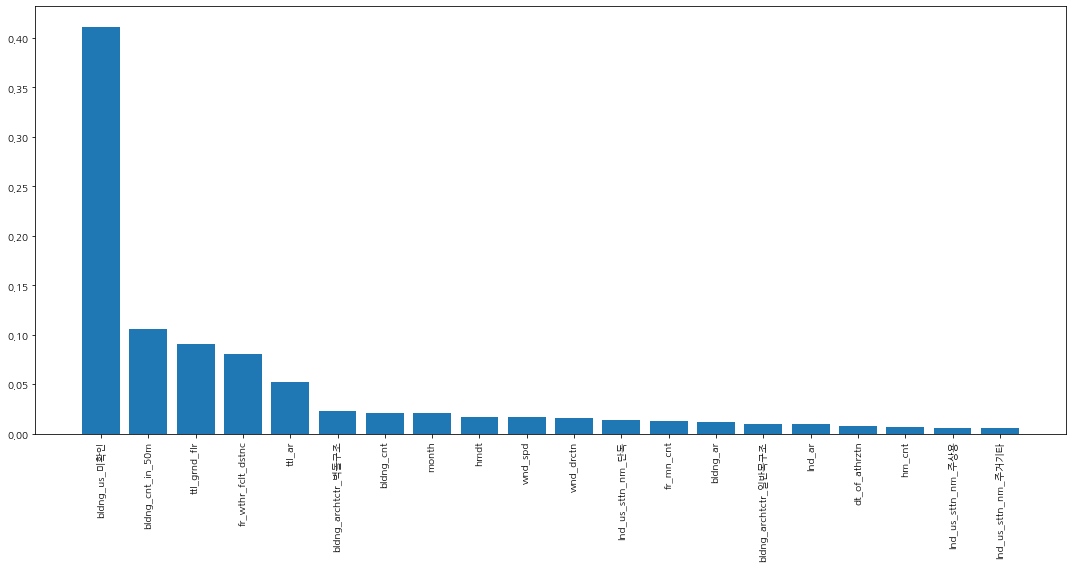

In [ ]:
feature_pd = pd.DataFrame(zip(X_test.columns, dtc.feature_importances_),columns=['feature', 'importance'])
feature_pd = feature_pd.sort_values('importance',ascending=False).head(20)

fig = plt.figure(figsize=(15, 8))
plt.bar(feature_pd.feature, feature_pd.importance)
plt.xticks(rotation=90)
plt.tight_layout()

### 2)Version2

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

In [ ]:
from sklearn.model_selection import GridSearchCV
dt_clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)

parameters = {'max_depth': [3, 5, 7],
              'min_samples_split': [3, 5],
              'splitter': ['best', 'random']}

grid_dt = GridSearchCV(estimator= dt_clf,param_grid = parameters, cv = 5, refit=True)
grid_dt.fit(X_smote, y_smote)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='entropy', max_depth=3,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=0, splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [3, 5, 7], 'min_samples_split': [3, 5],
                         'splitter': ['best', 'ra

In [ ]:
from sklearn.metrics import roc_auc_score,accuracy_score ,f1_score,recall_score
threshold_interval = np.linspace(0,1,101)
ths_table = pd.DataFrame()
idx = 0
for i in threshold_interval:
    valid_result_temp = pd.DataFrame(grid_dt.predict_proba(X_valid)[:,1],columns=['pred_prob'])
    valid_result_temp['binary'] = np.where(valid_result_temp['pred_prob']>=i,1,0)

    cm_temp0 = confusion_matrix(y_valid,valid_result_temp['binary'])
    cm_norm_temp0 = cm_temp0 / cm_temp0.sum(axis=1).reshape(-1,1)

    ths_table.loc[idx,'threshold']=i
#     ths_table.loc[idx,'accuracy'] = (cm_temp1[0,0]+cm_temp1[1,1])/(cm_temp1[0,0]+cm_temp1[0,1]+cm_temp1[1,0]+cm_temp1[1,1])
    ths_table.loc[idx,'accuracy'] = accuracy_score(y_valid, valid_result_temp['binary'])
    ths_table.loc[idx,'f1_score'] = f1_score(y_valid, valid_result_temp['binary'])
    ths_table.loc[idx,'recall'] = recall_score(y_valid, valid_result_temp['binary'])
    idx += 1
    
mx_idx = ths_table['f1_score'].idxmax()
print(ths_table.iloc[mx_idx])

optimal_threshold_rf = ths_table.iloc[mx_idx].threshold

test_result2 = pd.DataFrame(grid_dt.predict_proba(X_eval)[:,1],columns=['pred_prob'])
test_result2['rf_binary'] = np.where(test_result2['pred_prob']>=optimal_threshold_rf,1,0)

print("f1_score: ",f1_score(y_eval, test_result2['rf_binary']))
print("accuracy_score: ",accuracy_score(y_eval, test_result2['rf_binary']))
print("recall_score: ",recall_score(y_eval, test_result2['rf_binary']))
print("roc_auc_score: " ,roc_auc_score(y_eval,test_result2['rf_binary']))

threshold    0.690000
accuracy     0.744854
f1_score     0.446541
recall       0.559055
Name: 69, dtype: float64
f1_score:  0.44838921761998685
accuracy_score:  0.7567410843722818
recall_score:  0.5353218210361067
roc_auc_score:  0.6711104126517661


findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


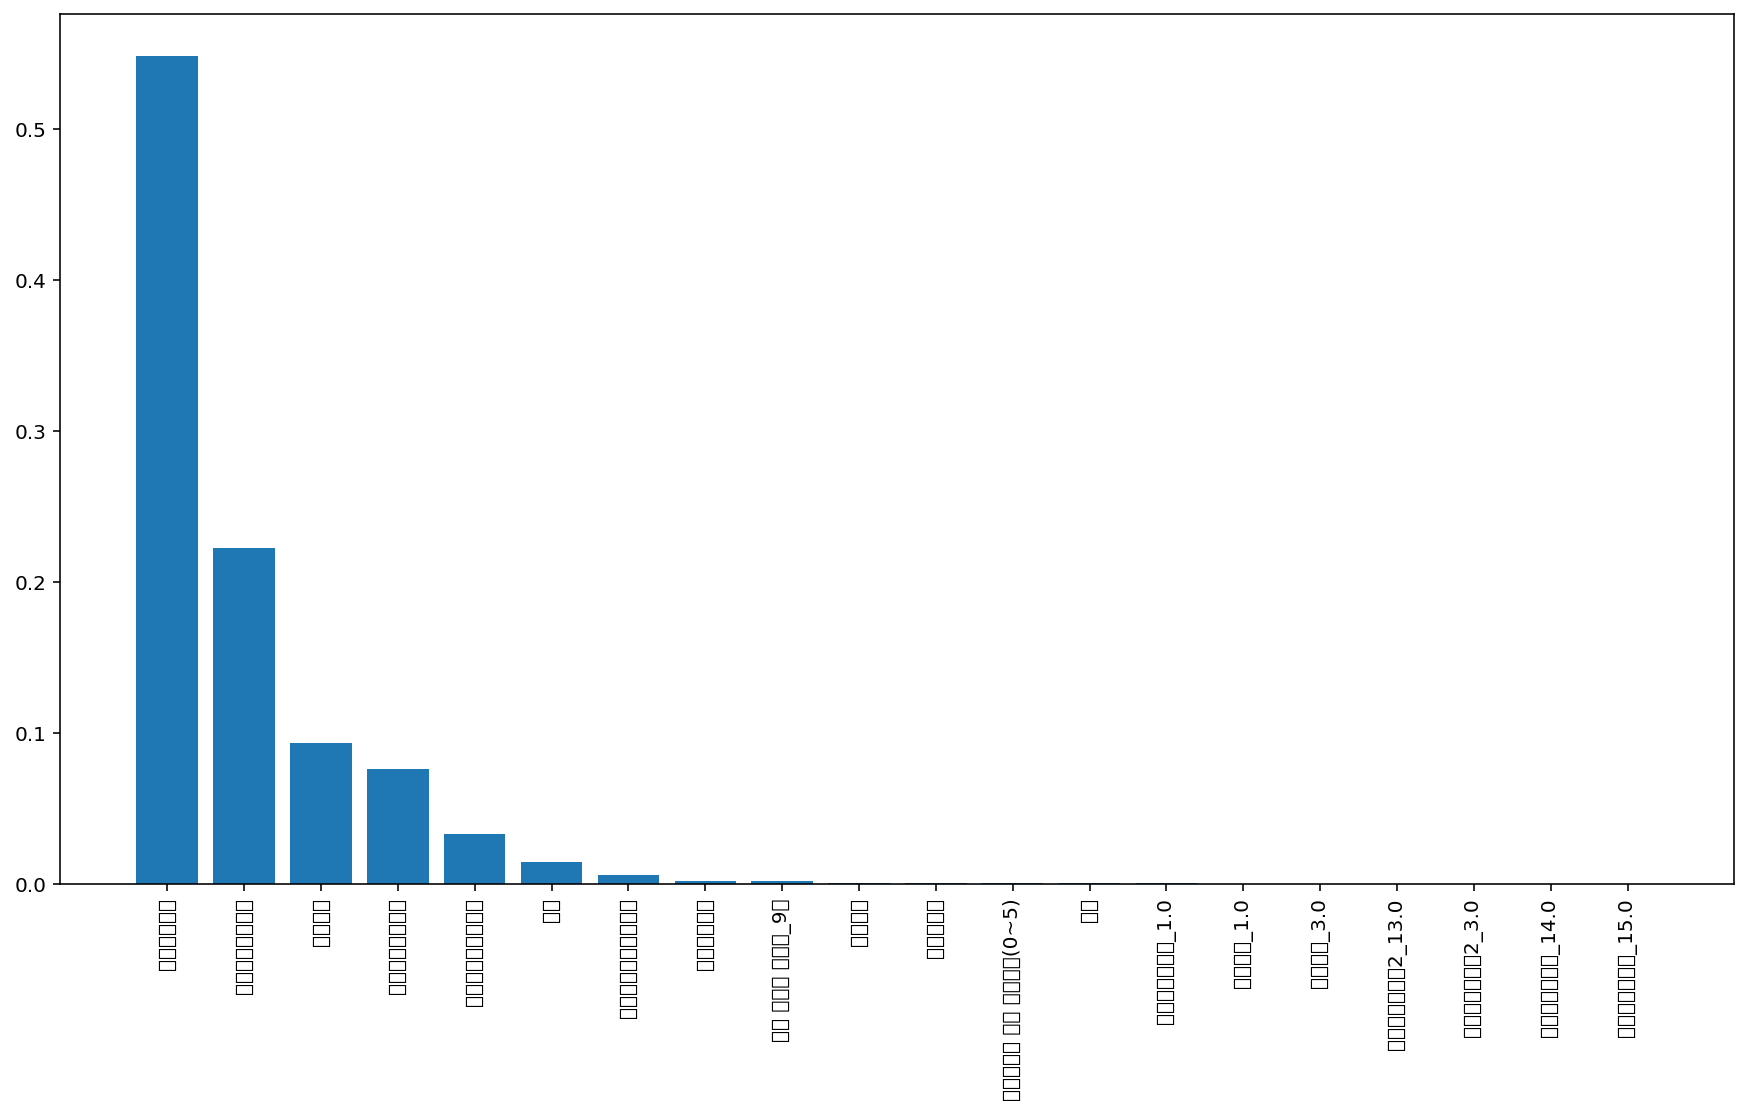

In [ ]:
final_dt =  grid_dt.best_estimator_
feature_pd = pd.DataFrame(zip(X_eval.columns, final_dt.feature_importances_),columns=['feature', 'importance'])
feature_pd = feature_pd.sort_values('importance',ascending=False).head(20)

fig = plt.figure(figsize=(15, 8))
plt.bar(feature_pd.feature, feature_pd.importance)
plt.xticks(rotation=90)
plt.show()

In [ ]:
feature_pd.feature

62                 건물승인여부
4                건물들지상층수합
0                    건물채수
28               소방용수시설거리
34              안전비상벨최소거리
10                     습도
2              건물층별합계전체면적
1                  건물건축면적
46          전기 에너지 사용량_9월
3                    토지면적
26                  소방서거리
16     배연설비의 성능 유지여부(0~5)
6                      온도
115           용도지역지구명_1.0
193              사용여부_1.0
93               건물구조_3.0
144         용도지역지구명2_13.0
134          용도지역지구명2_3.0
128          용도지역지구명_14.0
129          용도지역지구명_15.0
Name: feature, dtype: object

## 5.Random Forest

### 1)Version1

In [ ]:
X_valid=X_valid[X_train.columns]
X_test=X_test[X_train.columns]

In [ ]:
rf_model = RandomForestClassifier(random_state=47)

rf_params={'criterion':('entropy','gini'),'max_depth' : [5,7,9,11],'max_features' : ('auto','sqrt','log2')}
rf_grid = GridSearchCV(estimator=rf_model,param_grid=rf_params,
                        n_jobs=10, cv=5, refit=True, return_train_score=True)

rf_grid.fit(X=X_smote, y=y_smote)

print('final params', rf_grid.best_params_)
print('best score', rf_grid.best_score_)

final params {'criterion': 'gini', 'max_depth': 11, 'max_features': 'auto'}
best score 0.8777689488063141


In [ ]:
rf_grid.cv_results_

{'mean_fit_time': array([19.30843167, 19.28624873, 13.07325993, 26.43273339, 26.50920663,
        16.42779384, 34.59231825, 35.72869091, 24.6890801 , 42.143961  ,
        40.28458271, 26.40613184, 18.43771653, 18.95661864, 13.47336516,
        26.07161136, 26.05423923, 17.65947042, 32.10657868, 32.72318969,
        22.64569373, 38.56580858, 38.09432874, 19.25853052]),
 'std_fit_time': array([0.3395876 , 0.33079441, 0.23132385, 0.4696769 , 0.46488294,
        0.33285006, 0.5804112 , 0.57712082, 0.41614126, 0.57786064,
        0.52710385, 0.41374882, 0.12284447, 0.11686844, 0.10137034,
        0.40006412, 0.45735797, 0.28031737, 0.33004925, 0.32660432,
        0.20747485, 0.18091222, 0.16612739, 0.37282325]),
 'mean_score_time': array([0.36200185, 0.37115006, 0.36717405, 0.55477071, 0.42260876,
        0.40882711, 0.6195087 , 0.64156446, 0.59711828, 0.71222839,
        0.67491555, 0.67580013, 0.42691793, 0.43479347, 0.45448956,
        0.53344302, 0.53209534, 0.53010082, 0.67596636, 0.66

In [ ]:
rf_model = rf_grid.best_estimator_

threshold_interval = np.linspace(0,1,101)
ths_table = pd.DataFrame()
idx = 0

for i in threshold_interval:
    valid_result_temp = pd.DataFrame(rf_model.predict_proba(X_valid)[:,1],columns=['pred_prob'])
    valid_result_temp['binary'] = np.where(valid_result_temp['pred_prob']>=i,1,0)

    ths_table.loc[idx,'threshold'] = i
    ths_table.loc[idx,'accuracy'] = accuracy_score(y_valid, valid_result_temp['binary'])
    ths_table.loc[idx,'f1_score'] = f1_score(y_valid, valid_result_temp['binary'])
    ths_table.loc[idx,'recall'] = recall_score(y_valid, valid_result_temp['binary'])
    idx += 1
    
mx_idx = ths_table['f1_score'].idxmax()
# print(ths_table.iloc[mx_idx])

optimal_threshold_rf = ths_table.iloc[mx_idx].threshold
print('optimal threshold(RF) : ',optimal_threshold_rf)

test_result2 = pd.DataFrame(rf_model.predict_proba(X_test)[:,1],columns=['pred_prob'])
test_result2['lgb_binary'] = np.where(test_result2['pred_prob']>=optimal_threshold_rf,1,0)

print('f1_score : ', f1_score(y_test, test_result2['lgb_binary']))
print('accuracy : ', accuracy_score(y_test, test_result2['lgb_binary']))
print('recall : ', recall_score(y_test, test_result2['lgb_binary']))
print('roc_auc : ', roc_auc_score(y_test, test_result2['lgb_binary']))

optimal threshold(RF) :  0.32
f1_score :  0.41295051924251686
accuracy :  0.6518115942028986
recall :  0.6666666666666666
roc_auc :  0.6575676875277409


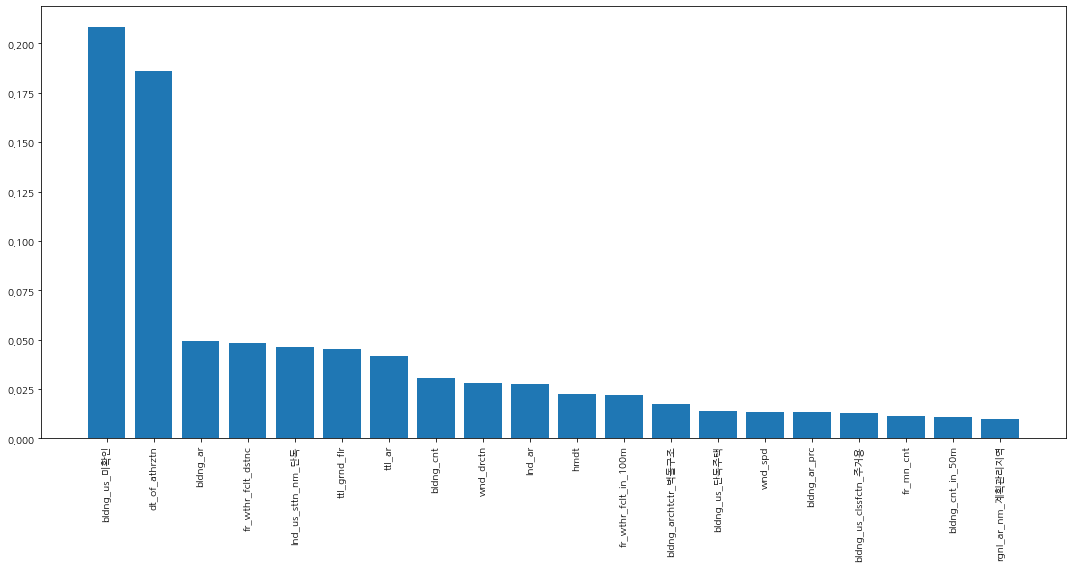

In [ ]:
feature_pd = pd.DataFrame(zip(X_test.columns, rf_model.feature_importances_),columns=['feature', 'importance'])
feature_pd = feature_pd.sort_values('importance',ascending=False).head(20)

fig = plt.figure(figsize=(15, 8))
plt.bar(feature_pd.feature, feature_pd.importance)
plt.xticks(rotation=90)
plt.tight_layout()

### 2)Version2

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
forest = RandomForestClassifier(n_estimators=100,class_weight='balanced',random_state=0)
forest_params={'criterion' : ["gini", "entropy"],'max_depth' : [5,7,9]}
forest_grid=GridSearchCV(estimator=forest,param_grid=forest_params,n_jobs=10,cv=5,refit=True,return_train_score=False)

forest_grid.fit(X_smote,y_smote)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=0,
                             

In [ ]:
from sklearn.metrics import roc_auc_score,accuracy_score ,f1_score,recall_score
threshold_interval = np.linspace(0,1,101)
ths_table = pd.DataFrame()
idx = 0
for i in threshold_interval:
    valid_result_temp = pd.DataFrame(forest_grid.predict_proba(X_valid)[:,1],columns=['pred_prob'])
    valid_result_temp['binary'] = np.where(valid_result_temp['pred_prob']>=i,1,0)

    cm_temp0 = confusion_matrix(y_valid,valid_result_temp['binary'])
    cm_norm_temp0 = cm_temp0 / cm_temp0.sum(axis=1).reshape(-1,1)

    ths_table.loc[idx,'threshold']=i
#     ths_table.loc[idx,'accuracy'] = (cm_temp1[0,0]+cm_temp1[1,1])/(cm_temp1[0,0]+cm_temp1[0,1]+cm_temp1[1,0]+cm_temp1[1,1])
    ths_table.loc[idx,'accuracy'] = accuracy_score(y_valid, valid_result_temp['binary'])
    ths_table.loc[idx,'f1_score'] = f1_score(y_valid, valid_result_temp['binary'])
    ths_table.loc[idx,'recall'] = recall_score(y_valid, valid_result_temp['binary'])
    idx += 1
    
mx_idx = ths_table['f1_score'].idxmax()
print(ths_table.iloc[mx_idx])

optimal_threshold_rf = ths_table.iloc[mx_idx].threshold

test_result2 = pd.DataFrame(forest_grid.predict_proba(X_eval)[:,1],columns=['pred_prob'])
test_result2['rf_binary'] = np.where(test_result2['pred_prob']>=optimal_threshold_rf,1,0)

print("f1_score: ", f1_score(y_eval, test_result2['rf_binary']))
print("accuracy_score: ",accuracy_score(y_eval, test_result2['rf_binary']))
print("recall_score: ",recall_score(y_eval, test_result2['rf_binary']))
print("roc_auc_score: " ,roc_auc_score(y_eval,test_result2['rf_binary']))

threshold    0.580000
accuracy     0.709191
f1_score     0.436833
recall       0.612598
Name: 58, dtype: float64
f1_score:  0.4393515930687535
accuracy_score:  0.7091910698753262
recall_score:  0.6169544740973313
roc_auc_score:  0.6735199113018663


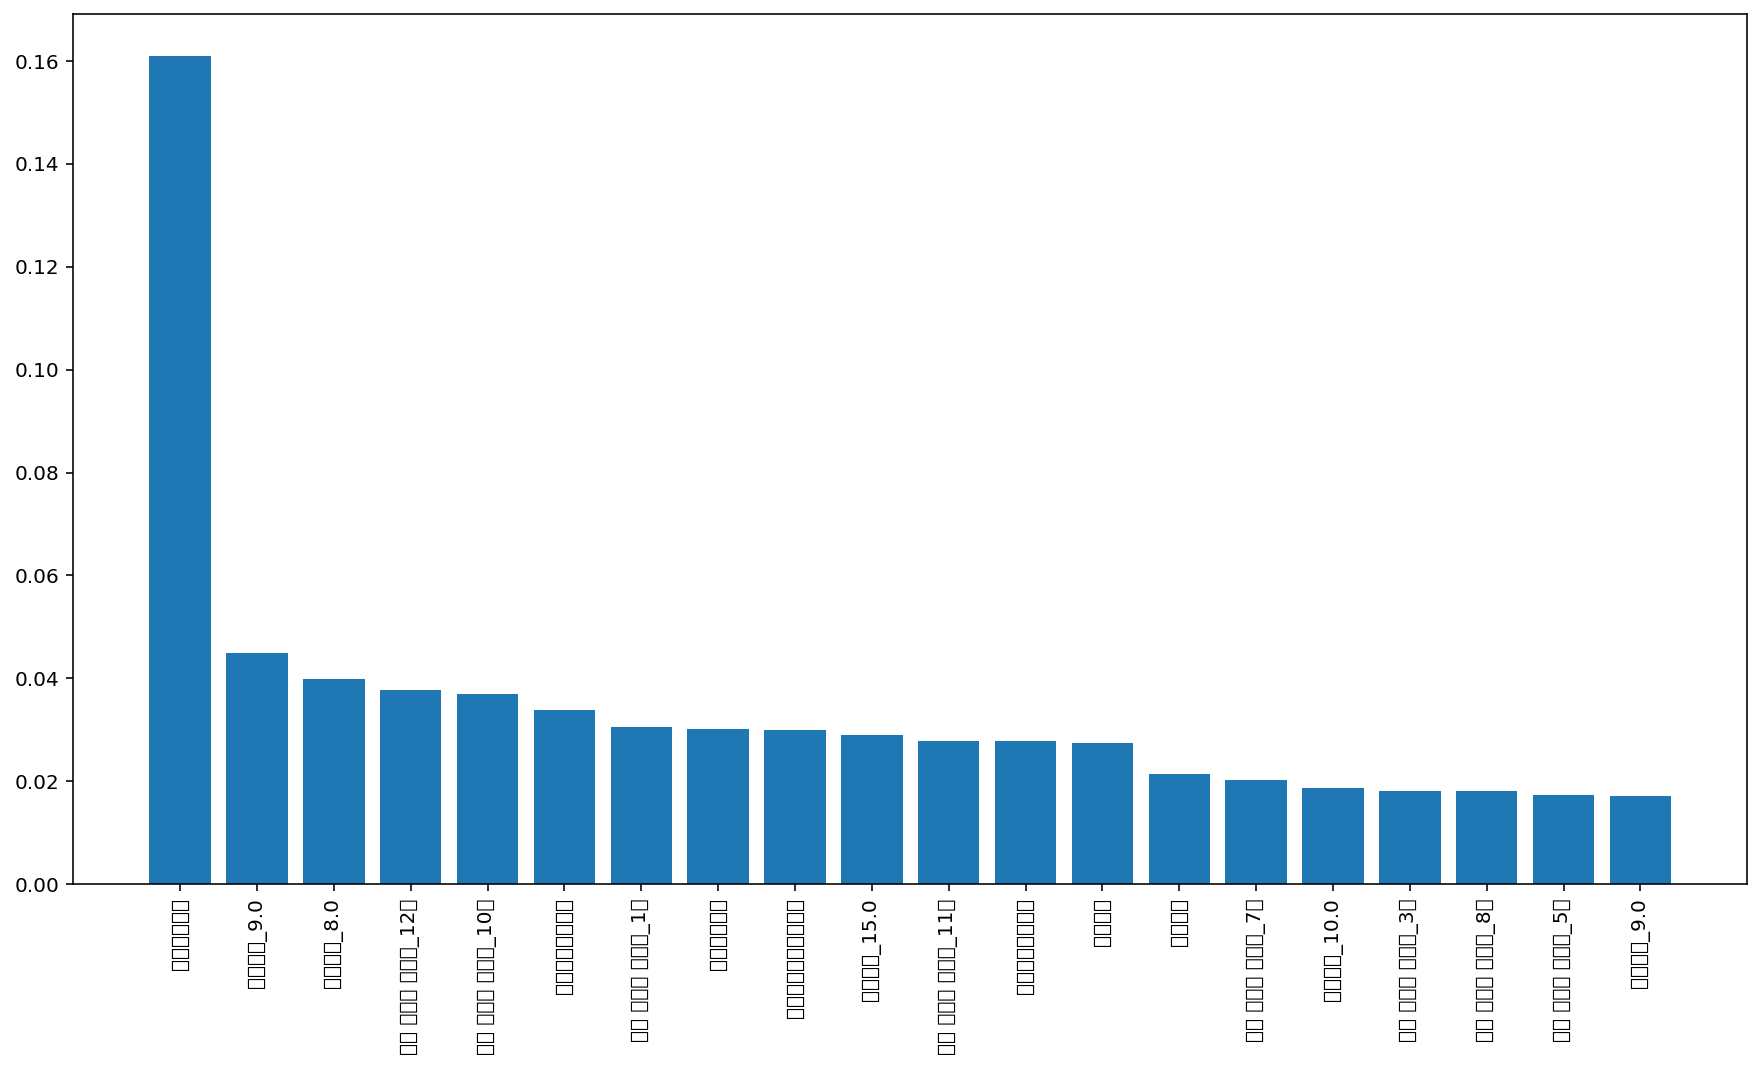

In [ ]:
final_fr =  forest_grid.best_estimator_
feature_pd = pd.DataFrame(zip(X_eval.columns, final_fr.feature_importances_),columns=['feature', 'importance'])
feature_pd = feature_pd.sort_values('importance',ascending=False).head(20)

fig = plt.figure(figsize=(15, 8))
plt.bar(feature_pd.feature, feature_pd.importance)
plt.xticks(rotation=90)
plt.show()

## 6.Logistic Regression

### 1)Version1

In [ ]:
lgst = LogisticRegression(random_state=37,max_iter = 1000)
lgst_params = [{'solver' : ['newton-cg'], 'penalty' : ['l1']},
               {'solver' : ['newton-cg'], 'penalty' : ['l2']},
               {'solver' : ['newton-cg'], 'penalty' : ['elasticnet']},
               {'solver' : ['newton-cg'], 'penalty' : ['none']},
               {'solver' : ['lbfgs'], 'penalty' : ['l1']},
               {'solver' : ['lbfgs'], 'penalty' : ['l2']},
               {'solver' : ['lbfgs'], 'penalty' : ['elasticnet']},
               {'solver' : ['lbfgs'], 'penalty' : ['none']},
               {'solver' : ['liblinear'], 'penalty' : ['l1']},
               {'solver' : ['liblinear'], 'penalty' : ['l2']},
               {'solver' : ['liblinear'], 'penalty' : ['elasticnet']},
               {'solver' : ['liblinear'], 'penalty' : ['none']},
               {'solver' : ['saga'], 'penalty' : ['l1']},
               {'solver' : ['saga'], 'penalty' : ['l2']},
               {'solver' : ['saga'], 'penalty' : ['elasticnet']},
               {'solver' : ['saga'], 'penalty' : ['none']}]

lgst_grid = GridSearchCV(estimator = lgst, param_grid = lgst_params, scoring='f1', 
                        n_jobs=10, cv=4, refit=True, return_train_score=True)

lgst_grid.fit(X_train, y_train)
print('final params', lgst_grid.best_params_)
print('best score', lgst_grid.best_score_)

final params {'penalty': 'none', 'solver': 'newton-cg'}
best score 0.9033536354330655


In [ ]:
lgst = lgst_grid.best_estimator_

threshold_interval = np.linspace(0,1,101)
ths_table = pd.DataFrame()
idx = 0

for i in threshold_interval:
    valid_result_temp = pd.DataFrame(lgst.predict_proba(X_valid)[:,1],columns=['pred_prob'])
    valid_result_temp['binary'] = np.where(valid_result_temp['pred_prob']>=i,1,0)

    ths_table.loc[idx,'threshold'] = i
    ths_table.loc[idx,'accuracy'] = accuracy_score(y_valid, valid_result_temp['binary'])
    ths_table.loc[idx,'f1_score'] = f1_score(y_valid, valid_result_temp['binary'])
    ths_table.loc[idx,'recall'] = recall_score(y_valid, valid_result_temp['binary'])
    idx += 1
    
mx_idx = ths_table['f1_score'].idxmax()
# print(ths_table.iloc[mx_idx])

optimal_threshold_lgst = ths_table.iloc[mx_idx].threshold
print('optimal threshold(lgst) : {}'.format(optimal_threshold_lgst))

test_result2 = pd.DataFrame(lgst.predict_proba(X_test)[:,1],columns=['pred_prob'])
test_result2['lgst_binary'] = np.where(test_result2['pred_prob']>=optimal_threshold_lgst,1,0)

print('f1_score : ', f1_score(y_test, test_result2['lgst_binary']))
print('accuracy : ', accuracy_score(y_test, test_result2['lgst_binary']))
print('recall : ', recall_score(y_test, test_result2['lgst_binary']))
print('roc_auc : ', roc_auc_score(y_test, test_result2['lgst_binary']))

optimal threshold(lgst) : 0.0
f1_score :  0.310376492194674
accuracy :  0.18369565217391304
recall :  1.0
roc_auc :  0.5


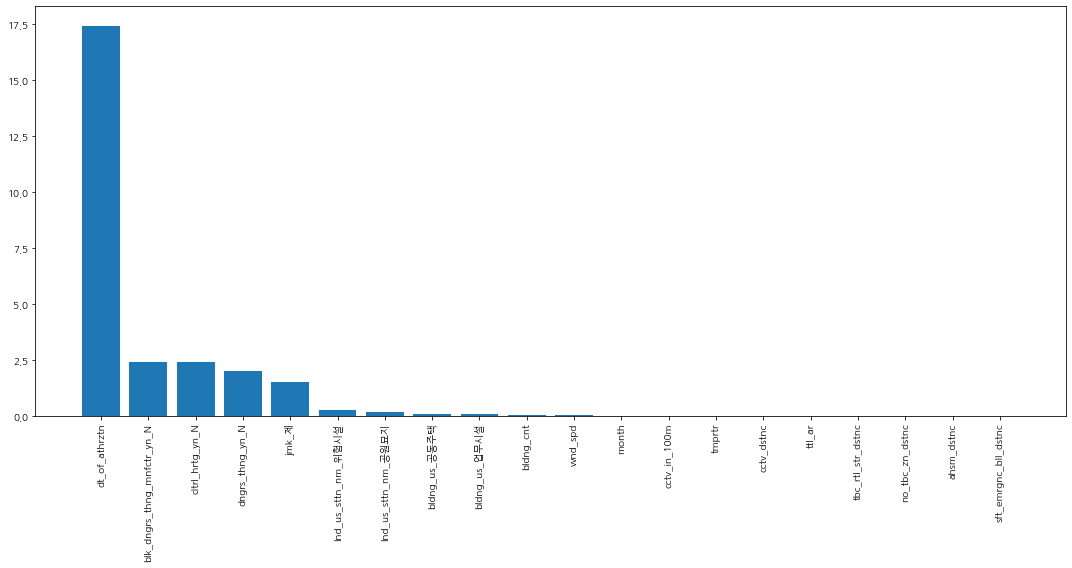

In [ ]:
feature_pd = pd.DataFrame(zip(X_test.columns, lgst.coef_[0]),columns=['feature', 'importance'])
feature_pd = feature_pd.sort_values('importance',ascending=False).head(20)

fig = plt.figure(figsize=(15, 8))
plt.bar(feature_pd.feature, feature_pd.importance)
plt.xticks(rotation=90)
plt.tight_layout()

### 2)Version2

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
model_lr = LogisticRegression(random_state=30,max_iter= 1000)

lr_params = [{'solver' : ['newton-cg'],'penalty' : ['l1']},
             {'solver' : ['newton-cg'],'penalty' : ['l2']},
             {'solver' : ['newton-cg'],'penalty' : ['elasticnet']},
             {'solver' : ['newton-cg'],'penalty' : ['none']},
             {'solver' : ['lbfgs'],'penalty' : ['l1']},
             {'solver' : ['lbfgs'],'penalty' : ['l2']},
             {'solver' : ['lbfgs'],'penalty' : ['elasticnet']},
             {'solver' : ['lbfgs'],'penalty' : ['none']},
             {'solver' : ['liblinear'],'penalty' : ['l1']},
             {'solver' : ['liblinear'],'penalty' : ['l2']},
             {'solver' : ['liblinear'],'penalty' : ['elasticnet']},
             {'solver' : ['liblinear'],'penalty' : ['none']},
             {'solver' : ['saga'],'penalty' : ['l1']},
             {'solver' : ['saga'],'penalty' : ['l2']},
             {'solver' : ['saga'],'penalty' : ['elasticnet']},
             {'solver' : ['saga'],'penalty' : ['none']}] 
grid_lr = GridSearchCV(estimator= model_lr, param_grid=lr_params , cv = 5, refit=True,)
grid_lr.fit(X_smote, y_smote)

In [ ]:
from sklearn.metrics import roc_auc_score,accuracy_score ,f1_score,recall_score
threshold_interval = np.linspace(0,1,101)
ths_table = pd.DataFrame()
idx = 0
for i in threshold_interval:
    valid_result_temp = pd.DataFrame(grid_lr.predict_proba(X_valid)[:,1],columns=['pred_prob'])
    valid_result_temp['binary'] = np.where(valid_result_temp['pred_prob']>=i,1,0)

    cm_temp0 = confusion_matrix(y_valid,valid_result_temp['binary'])
    cm_norm_temp0 = cm_temp0 / cm_temp0.sum(axis=1).reshape(-1,1)

    ths_table.loc[idx,'threshold']=i
#     ths_table.loc[idx,'accuracy'] = (cm_temp1[0,0]+cm_temp1[1,1])/(cm_temp1[0,0]+cm_temp1[0,1]+cm_temp1[1,0]+cm_temp1[1,1])
    ths_table.loc[idx,'accuracy'] = accuracy_score(y_valid, valid_result_temp['binary'])
    ths_table.loc[idx,'f1_score'] = f1_score(y_valid, valid_result_temp['binary'])
    ths_table.loc[idx,'recall'] = recall_score(y_valid, valid_result_temp['binary'])
    idx += 1
    
mx_idx = ths_table['f1_score'].idxmax()
print(ths_table.iloc[mx_idx])

optimal_threshold_rf = ths_table.iloc[mx_idx].threshold

test_result2 = pd.DataFrame(grid_lr.predict_proba(X_eval)[:,1],columns=['pred_prob'])
test_result2['rf_binary'] = np.where(test_result2['pred_prob']>=optimal_threshold_rf,1,0)

print("f1_score: ",f1_score(y_eval, test_result2['rf_binary']))
print("accuracy_score: ",accuracy_score(y_eval, test_result2['rf_binary']))
print("recall_score: ",recall_score(y_eval, test_result2['rf_binary']))
print("roc_auc_score: " ,roc_auc_score(y_eval,test_result2['rf_binary']))

threshold    0.690000
accuracy     0.744854
f1_score     0.446541
recall       0.559055
Name: 69, dtype: float64
f1_score:  0.44838921761998685
accuracy_score:  0.7567410843722818
recall_score:  0.5353218210361067
roc_auc_score:  0.6711104126517661


## 7.XGB Model

### 1)Version1

In [ ]:
xgb = XGBClassifier(objective='binary:logistic',booster='gbtree', n_estimators=100, random_state=47)
xgb_param_grid = {'max_depth': [5,8,11],'learning_rate':[0.01, 0.1, 1]} 
xgb_grid = GridSearchCV(estimator=xgb, param_grid=xgb_param_grid, scoring='f1', 
                        n_jobs=10, cv=4, refit=True, return_train_score=True)

xgb_grid.fit(X_train, y_train, early_stopping_rounds=40,
             eval_metric="error", eval_set=[(X_eval, y_eval)])
print('final params', xgb_grid.best_params_)
print('best score', xgb_grid.best_score_)

[0]	validation_0-error:0.18487
Will train until validation_0-error hasn't improved in 40 rounds.
[1]	validation_0-error:0.18487
[2]	validation_0-error:0.18487
[3]	validation_0-error:0.18487
[4]	validation_0-error:0.18487
[5]	validation_0-error:0.18487
[6]	validation_0-error:0.18487
[7]	validation_0-error:0.18487
[8]	validation_0-error:0.18487
[9]	validation_0-error:0.18487
[10]	validation_0-error:0.18487
[11]	validation_0-error:0.18487
[12]	validation_0-error:0.18487
[13]	validation_0-error:0.18487
[14]	validation_0-error:0.18487
[15]	validation_0-error:0.18487
[16]	validation_0-error:0.18487
[17]	validation_0-error:0.18487
[18]	validation_0-error:0.18487
[19]	validation_0-error:0.18487
[20]	validation_0-error:0.18487
[21]	validation_0-error:0.18487
[22]	validation_0-error:0.18487
[23]	validation_0-error:0.18511
[24]	validation_0-error:0.18511
[25]	validation_0-error:0.18487
[26]	validation_0-error:0.18487
[27]	validation_0-error:0.18487
[28]	validation_0-error:0.18487
[29]	validation_

In [ ]:
xgb_grid.cv_results_

{'mean_fit_time': array([ 81.68652928, 138.197442  , 193.39872414,  89.14098126,
        141.75098354, 199.92882425, 131.97166783, 175.50699353,
        139.6187312 ]),
 'std_fit_time': array([ 0.97199371,  0.57300756,  4.83596216,  1.75144079,  2.68309061,
         1.14131373, 25.76970303, 51.94031544,  8.49163869]),
 'mean_score_time': array([0.62197822, 0.44013005, 0.45387334, 0.42098159, 0.50290871,
        0.48453194, 0.48013741, 0.30366153, 0.23285496]),
 'std_score_time': array([0.01487084, 0.01228236, 0.03638621, 0.01797873, 0.06822575,
        0.00908305, 0.02770532, 0.03306355, 0.03150882]),
 'param_learning_rate': masked_array(data=[0.01, 0.01, 0.01, 0.1, 0.1, 0.1, 1, 1, 1],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[5, 8, 11, 5, 8, 11, 5, 8, 11],
              mask=[False, False, False, False, False, False, False, False,
   

In [ ]:
xgb = XGBClassifier(n_estimators=100, learning_rate = 1, max_depth = 5)
xgb.fit(X_train,y_train,early_stopping_rounds=40,
             eval_metric="error", eval_set=[(X_valid, y_valid)])

[0]	validation_0-error:0.18487
Will train until validation_0-error hasn't improved in 40 rounds.
[1]	validation_0-error:0.18487
[2]	validation_0-error:0.18487
[3]	validation_0-error:0.18487
[4]	validation_0-error:0.18487
[5]	validation_0-error:0.18487
[6]	validation_0-error:0.18487
[7]	validation_0-error:0.18487
[8]	validation_0-error:0.18487
[9]	validation_0-error:0.18487
[10]	validation_0-error:0.18487
[11]	validation_0-error:0.18487
[12]	validation_0-error:0.18487
[13]	validation_0-error:0.18487
[14]	validation_0-error:0.18487
[15]	validation_0-error:0.18487
[16]	validation_0-error:0.18487
[17]	validation_0-error:0.18487
[18]	validation_0-error:0.18487
[19]	validation_0-error:0.18487
[20]	validation_0-error:0.18487
[21]	validation_0-error:0.18487
[22]	validation_0-error:0.18487
[23]	validation_0-error:0.18511
[24]	validation_0-error:0.18511
[25]	validation_0-error:0.18487
[26]	validation_0-error:0.18487
[27]	validation_0-error:0.18487
[28]	validation_0-error:0.18487
[29]	validation_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [ ]:
xgb = xgb_grid.best_estimator_

threshold_interval = np.linspace(0,1,101)
ths_table = pd.DataFrame()
idx = 0

for i in threshold_interval:
    valid_result_temp = pd.DataFrame(xgb.predict_proba(X_valid)[:,1],columns=['pred_prob'])
    valid_result_temp['binary'] = np.where(valid_result_temp['pred_prob']>=i,1,0)

    ths_table.loc[idx,'threshold'] = i
    ths_table.loc[idx,'accuracy'] = accuracy_score(y_valid, valid_result_temp['binary'])
    ths_table.loc[idx,'f1_score'] = f1_score(y_valid, valid_result_temp['binary'])
    ths_table.loc[idx,'recall'] = recall_score(y_valid, valid_result_temp['binary'])
    idx += 1
    
mx_idx = ths_table['f1_score'].idxmax()
# print(ths_table.iloc[mx_idx])

optimal_threshold_xgb = ths_table.iloc[mx_idx].threshold
print('optimal threshold(XGB) : {}'.format(optimal_threshold_xgb))

test_result2 = pd.DataFrame(xgb.predict_proba(X_test)[:,1],columns=['pred_prob'])
test_result2['xgb_binary'] = np.where(test_result2['pred_prob']>=optimal_threshold_xgb,1,0)

print('f1_score : ', f1_score(y_test, test_result2['xgb_binary']))
print('accuracy : ', accuracy_score(y_test, test_result2['xgb_binary']))
print('recall : ', recall_score(y_test, test_result2['xgb_binary']))
print('roc_auc : ', roc_auc_score(y_test, test_result2['xgb_binary']))

optimal threshold(XGB) : 0.0
f1_score :  0.310376492194674
accuracy :  0.18369565217391304
recall :  1.0
roc_auc :  0.5


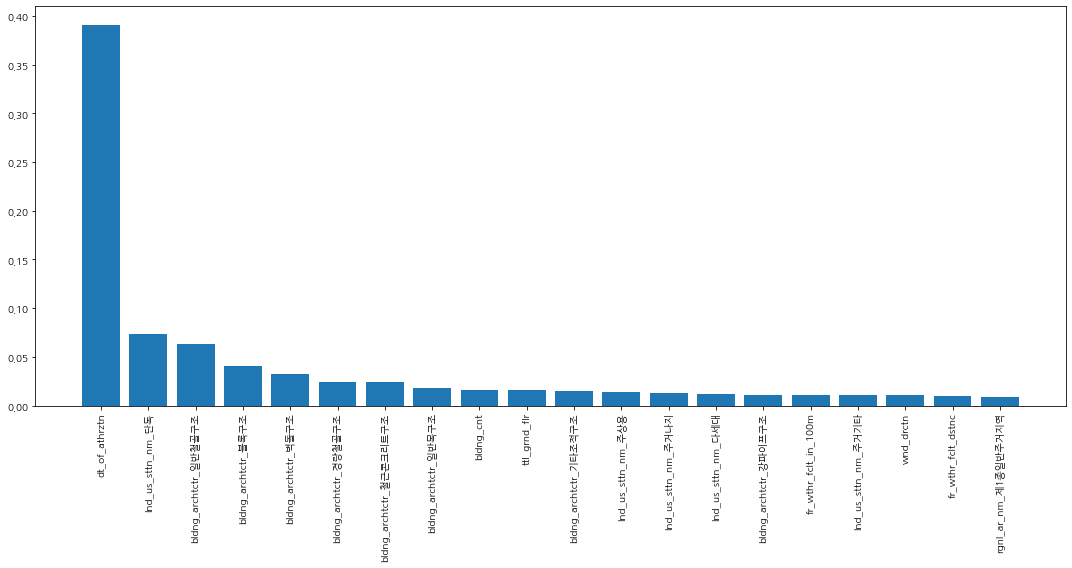

In [ ]:
feature_pd = pd.DataFrame(zip(X_test.columns, xgb.feature_importances_),columns=['feature', 'importance'])
feature_pd = feature_pd.sort_values('importance',ascending=False).head(20)

fig = plt.figure(figsize=(15, 8))
plt.bar(feature_pd.feature, feature_pd.importance)
plt.xticks(rotation=90)
plt.tight_layout()

### 2)Version2

In [ ]:
xgb = XGBClassifier(objective='binary:logistic',booster='gbtree', n_estimators=100, random_state=47)
xgb_param_grid = {'max_depth': [5,8,11],'learning_rate':[0.01, 0.1, 1]} 
xgb_grid = GridSearchCV(estimator=xgb, param_grid=xgb_param_grid, scoring='f1', 
                        n_jobs=10, cv=4, refit=True, return_train_score=True)

xgb_grid.fit(X_smote, y_smote, early_stopping_rounds=25, 
             eval_metric="error", eval_set=[(X_valid, y_valid)])
print('final params', xgb_grid.best_params_)
print('best score', xgb_grid.best_score_)

[0]	validation_0-error:0.59728
Will train until validation_0-error hasn't improved in 25 rounds.
[1]	validation_0-error:0.56132
[2]	validation_0-error:0.51580
[3]	validation_0-error:0.51087
[4]	validation_0-error:0.49493
[5]	validation_0-error:0.49783
[6]	validation_0-error:0.50246
[7]	validation_0-error:0.49956
[8]	validation_0-error:0.49435
[9]	validation_0-error:0.49377
[10]	validation_0-error:0.49232
[11]	validation_0-error:0.50072
[12]	validation_0-error:0.49985
[13]	validation_0-error:0.49377
[14]	validation_0-error:0.49145
[15]	validation_0-error:0.48217
[16]	validation_0-error:0.47985
[17]	validation_0-error:0.47405
[18]	validation_0-error:0.47202
[19]	validation_0-error:0.46767
[20]	validation_0-error:0.46100
[21]	validation_0-error:0.45520
[22]	validation_0-error:0.44216
[23]	validation_0-error:0.43955
[24]	validation_0-error:0.43201
[25]	validation_0-error:0.42969
[26]	validation_0-error:0.43027
[27]	validation_0-error:0.43810
[28]	validation_0-error:0.43549
[29]	validation_

In [ ]:
xgb = xgb_grid.best_estimator_
xgb.fit(X_smote,y_smote)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=47,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [ ]:
eval_pred = xgb.predict(X_eval)
print(f1_score(y_eval, eval_pred, pos_label=1))

0.4647599591419816


In [ ]:
xgb.score(X_eval, y_eval)

0.6961438097999421

In [ ]:
fpr, tpr, threshold = roc_curve(y_eval,eval_pred)
roc_auc = auc(fpr,tpr)
roc_auc

0.7031599268441373

In [ ]:
from sklearn.metrics import precision_score, recall_score
print(recall_score(y_eval, eval_pred,pos_label=1))
print(precision_score(y_eval, eval_pred,pos_label=1))

0.7142857142857143
0.3444360333080999


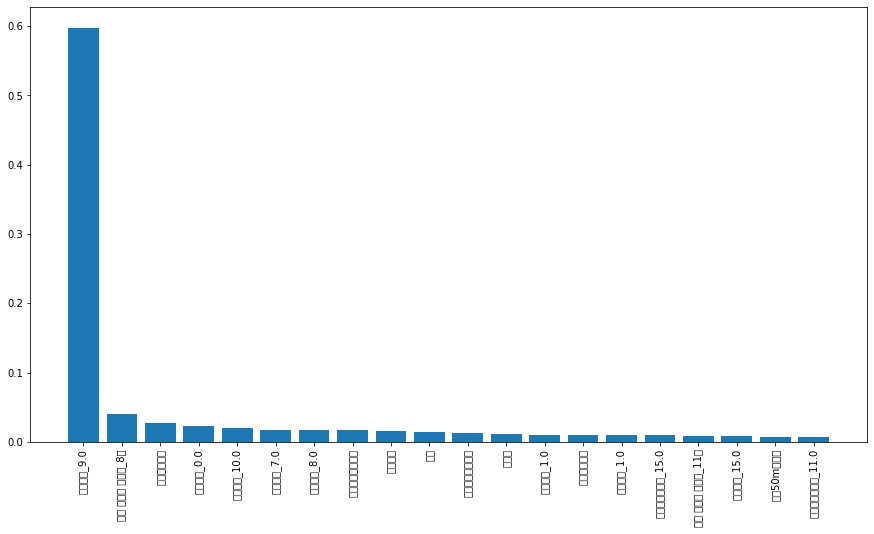

In [ ]:
feature_pd = pd.DataFrame(zip(X_test.columns, xgb.feature_importances_),columns=['feature', 'importance'])
feature_pd = feature_pd.sort_values('importance',ascending=False).head(20)

fig = plt.figure(figsize=(15, 8))
plt.bar(feature_pd.feature, feature_pd.importance)
plt.xticks(rotation=90)
plt.show()

In [ ]:
feature_pd.feature

99           건물구조_9.0
45      전기 에너지 사용량_8월
62             건물승인여부
192          사용여부_0.0
100         건물구조_10.0
97           건물구조_7.0
98           건물구조_8.0
4            건물들지상층수합
0                건물채수
8                  풍속
28           소방용수시설거리
7                 강수량
193          사용여부_1.0
1              건물건축면적
91           건물구조_1.0
129      용도지역지구명_15.0
48     전기 에너지 사용량_11월
105         건물구조_15.0
37           반경50m건물수
158      토지이용상황명_11.0
Name: feature, dtype: object

## 8.LGB Model

### 1)Version1

In [ ]:
lgb = LGBMClassifier(n_estimators=100)
lgbm_params={'learning_rate':[0.01,0.1,0.4,0.7,1],'max_depth' : [5,7,9,11], 'num_leaves' : [30,110,400,800]}

lgbm_grid = GridSearchCV(estimator=lgb, param_grid=lgbm_params, scoring='f1', 
                        n_jobs=10, cv=4, refit=True, return_train_score=True)

lgbm_grid.fit(X_train,y_train,early_stopping_rounds=40,
             eval_metric="error", eval_set=[(X_valid, y_valid)])
print('final params', lgbm_grid.best_params_)
print('best score', lgbm_grid.best_score_)

[1]	valid_0's binary_error: 0.184872	valid_0's binary_logloss: 0.686977
Training until validation scores don't improve for 40 rounds
[2]	valid_0's binary_error: 0.184872	valid_0's binary_logloss: 0.680882
[3]	valid_0's binary_error: 0.184872	valid_0's binary_logloss: 0.674944
[4]	valid_0's binary_error: 0.184872	valid_0's binary_logloss: 0.669157
[5]	valid_0's binary_error: 0.184872	valid_0's binary_logloss: 0.663516
[6]	valid_0's binary_error: 0.184872	valid_0's binary_logloss: 0.658019
[7]	valid_0's binary_error: 0.184872	valid_0's binary_logloss: 0.65266
[8]	valid_0's binary_error: 0.184872	valid_0's binary_logloss: 0.647436
[9]	valid_0's binary_error: 0.184872	valid_0's binary_logloss: 0.642343
[10]	valid_0's binary_error: 0.184872	valid_0's binary_logloss: 0.637378
[11]	valid_0's binary_error: 0.184872	valid_0's binary_logloss: 0.632537
[12]	valid_0's binary_error: 0.184872	valid_0's binary_logloss: 0.627818
[13]	valid_0's binary_error: 0.184872	valid_0's binary_logloss: 0.623216


In [ ]:
lgbm_grid.cv_results_

{'mean_fit_time': array([3.29767001, 2.91650867, 2.82285851, 2.98218733, 3.43158847,
        3.7816146 , 4.28922802, 3.79344845, 3.5407418 , 4.8168183 ,
        5.42287374, 5.4755221 , 3.63928843, 5.3949554 , 7.37532943,
        7.55855823, 2.95047468, 3.03190362, 2.90391207, 2.91395772,
        3.12000149, 3.92717165, 3.812415  , 3.63644534, 3.33714026,
        4.41531253, 4.63086653, 4.92870772, 3.6566537 , 5.00743824,
        5.98099941, 6.52034223, 3.05308497, 2.8866961 , 2.87970263,
        2.89210725, 2.95005357, 3.48312426, 3.56248868, 3.49608099,
        2.98943448, 4.19760704, 4.9342618 , 4.79642361, 3.04495656,
        4.4582029 , 6.60057497, 7.10214692, 2.90834373, 2.81139332,
        2.75693607, 3.14129525, 3.05177867, 3.59334749, 3.6780982 ,
        3.59595722, 2.86352563, 4.90700567, 5.13677347, 5.41760993,
        3.21930748, 4.81025797, 7.18153816, 8.27299571, 2.94932973,
        3.16084355, 3.04030597, 3.21654087, 3.26339144, 3.48251122,
        3.63631248, 3.45079321,

In [ ]:
lgb = lgbm_grid.best_estimator_

threshold_interval = np.linspace(0,1,101)
ths_table = pd.DataFrame()
idx = 0

for i in threshold_interval:
    valid_result_temp = pd.DataFrame(lgb.predict_proba(X_valid)[:,1],columns=['pred_prob'])
    valid_result_temp['binary'] = np.where(valid_result_temp['pred_prob']>=i,1,0)

    ths_table.loc[idx,'threshold'] = i
    ths_table.loc[idx,'accuracy'] = accuracy_score(y_valid, valid_result_temp['binary'])
    ths_table.loc[idx,'f1_score'] = f1_score(y_valid, valid_result_temp['binary'])
    ths_table.loc[idx,'recall'] = recall_score(y_valid, valid_result_temp['binary'])
    idx += 1
    
mx_idx = ths_table['f1_score'].idxmax()
# print(ths_table.iloc[mx_idx])

optimal_threshold_lgb = ths_table.iloc[mx_idx].threshold
print('optimal threshold(LGB) : ',optimal_threshold_lgb)

test_result2 = pd.DataFrame(lgb.predict_proba(X_test)[:,1],columns=['pred_prob'])
test_result2['lgb_binary'] = np.where(test_result2['pred_prob']>=optimal_threshold_lgb,1,0)

print('f1_score : ', f1_score(y_test, test_result2['lgb_binary']))
print('accuracy : ', accuracy_score(y_test, test_result2['lgb_binary']))
print('recall : ', recall_score(y_test, test_result2['lgb_binary']))
print('roc_auc : ', roc_auc_score(y_test, test_result2['lgb_binary']))

optimal threshold(LGB) :  0.0
f1_score :  0.310376492194674
accuracy :  0.18369565217391304
recall :  1.0
roc_auc :  0.5


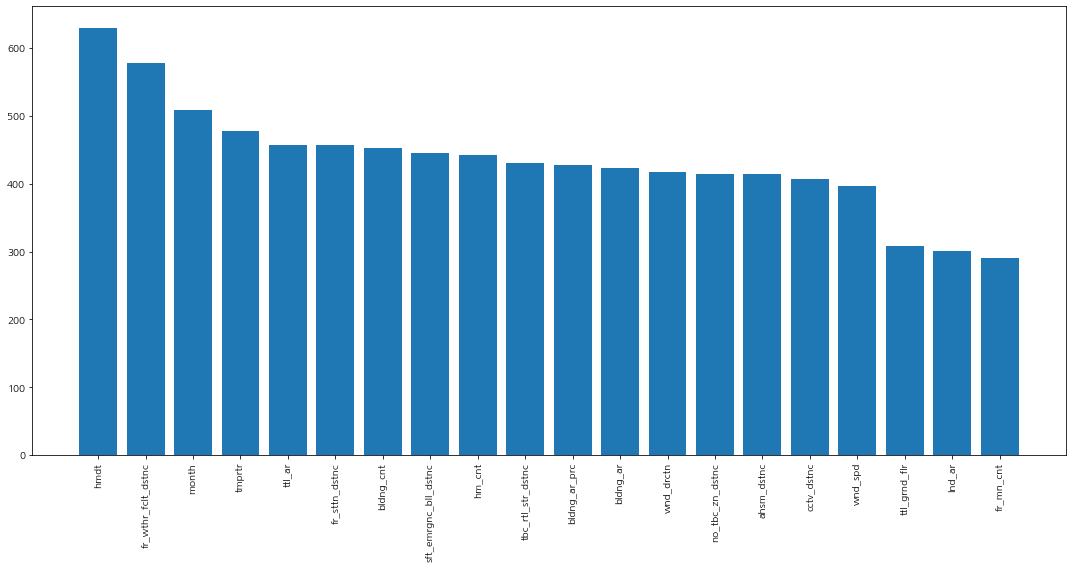

In [ ]:
feature_pd = pd.DataFrame(zip(X_test.columns, lgb.feature_importances_),columns=['feature', 'importance'])
feature_pd = feature_pd.sort_values('importance',ascending=False).head(20)

fig = plt.figure(figsize=(15, 8))
plt.bar(feature_pd.feature, feature_pd.importance)
plt.xticks(rotation=90)
plt.tight_layout()

### 2)Version2

In [ ]:
lgb = LGBMClassifier(n_estimators=100)
lgbm_params={'learning_rate':[0.01,0.1,1],'max_depth' : [5,7,9,11], 'num_leaves' : [30,110,400,800]}

lgbm_grid = GridSearchCV(estimator=lgb, param_grid=lgbm_params, scoring='f1', 
                        n_jobs=10, cv=4, refit=True, return_train_score=True)

lgbm_grid.fit(X_smote,y_smote, early_stopping_rounds=40,
             eval_metric="error", eval_set=[(X_valid, y_valid)])
print('final params', lgbm_grid.best_params_)
print('best score', lgbm_grid.best_score_)

[1]	valid_0's binary_error: 0.409684	valid_0's binary_logloss: 0.68976
Training until validation scores don't improve for 40 rounds
[2]	valid_0's binary_error: 0.373442	valid_0's binary_logloss: 0.672426
[3]	valid_0's binary_error: 0.358655	valid_0's binary_logloss: 0.690511
[4]	valid_0's binary_error: 0.354596	valid_0's binary_logloss: 0.695401
[5]	valid_0's binary_error: 0.347637	valid_0's binary_logloss: 0.691468
[6]	valid_0's binary_error: 0.357495	valid_0's binary_logloss: 0.734198
[7]	valid_0's binary_error: 0.351406	valid_0's binary_logloss: 0.741127
[8]	valid_0's binary_error: 0.358655	valid_0's binary_logloss: 0.753113
[9]	valid_0's binary_error: 0.356335	valid_0's binary_logloss: 0.756712
[10]	valid_0's binary_error: 0.340389	valid_0's binary_logloss: 0.736211
[11]	valid_0's binary_error: 0.328211	valid_0's binary_logloss: 0.748262
[12]	valid_0's binary_error: 0.316324	valid_0's binary_logloss: 0.75749
[13]	valid_0's binary_error: 0.330821	valid_0's binary_logloss: 0.78932
[1

In [ ]:
lgb = lgbm_grid.best_estimator_

valid_pred = lgb.predict(X_eval)
fpr, tpr, threshold = roc_curve(y_eval,valid_pred)
roc_auc = auc(fpr,tpr)
roc_auc

0.6790116254401968

In [ ]:
print(f1_score(y_eval, valid_pred, pos_label=1))

0.43035714285714277


In [ ]:
lgb.score(X_eval, y_eval)

0.6300376920846622

In [ ]:
from sklearn.metrics import precision_score, recall_score
print(recall_score(y_eval, valid_pred,pos_label=1))
print(precision_score(y_eval, valid_pred,pos_label=1))

0.7566718995290423
0.3006862133499688


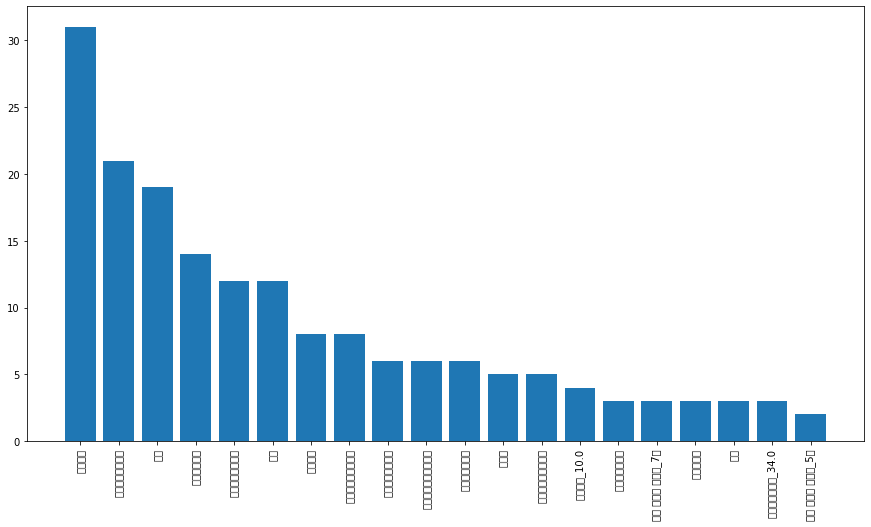

In [ ]:
feature_pd = pd.DataFrame(zip(X_test.columns, lgb.feature_importances_),columns=['feature', 'importance'])
feature_pd = feature_pd.sort_values('importance',ascending=False).head(20)
fig = plt.figure(figsize=(15, 8))
plt.bar(feature_pd.feature, feature_pd.importance)
plt.xticks(rotation=90)
plt.show()
##깨진 폰트는 아래에 따로 출력함.

In [ ]:
feature_pd.feature

0               건물채수
4           건물들지상층수합
10                습도
1             건물건축면적
28          소방용수시설거리
8                 풍속
3               토지면적
35         자동심장충격기거리
36          금연구역최소거리
2         건물층별합계전체면적
29           관할소방서인원
7                강수량
34         안전비상벨최소거리
100        건물구조_10.0
27           건물면적당가격
44     전기 에너지 사용량_7월
26             소방서거리
9                 풍향
181     토지이용상황명_34.0
42     전기 에너지 사용량_5월
Name: feature, dtype: object